# 📷 Cifar-10 Image Classifiction
The `CIFAR-10` dataset consists of `60000` `32x32` color images in `10` classes, with `6000` images per class. There are `50000` training images and `10000` test images.

## 🧠 Problem Statement
The goal of this project is to explore and understand the training dynamics of a neural network on the CIFAR-10 image classification task, with a specific focus on the ''evolution of weights and biases across epochs'' and their implications on model generalization. 

In this notebook we are going to build a CNN model that can classify images of various objects. We have `10` class of images:
1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

# Required Libraries

In [1]:
# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Dataset and transformations
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Numpy & plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# OS & utility
import os
from datetime import datetime
from tqdm import tqdm

# WeightWatcher for ESD analysis
import weightwatcher as ww

# Warning suppression
import warnings
warnings.filterwarnings("ignore")

# 📥 Load the data

In [2]:
import os
import pickle
import numpy as np

def load_all_cifar10(data_dir):
    data = []
    labels = []

    # Load all 5 training batches
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        with open(batch_file, 'rb') as f:
            batch = pickle.load(f, encoding='latin1')
            data.append(batch['data'])
            labels += batch['labels']

    # Load the test batch
    test_batch_file = os.path.join(data_dir, 'test_batch')
    with open(test_batch_file, 'rb') as f:
        batch = pickle.load(f, encoding='latin1')
        data.append(batch['data'])
        labels += batch['labels']

    X = np.concatenate(data, axis=0)  # Shape: (60000, 3072)
    y = np.array(labels)              # Shape: (60000,)

    # Reshape X to (60000, 32, 32, 3)
    X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return X, y

# Load the raw data
data_dir = 'cifar-10-batches-py'
X, y = load_all_cifar10(data_dir)

print(f"Shape of X: {X.shape}")  # (60000, 32, 32, 3)
print(f"Shape of y: {y.shape}")  # (60000,)


Shape of X: (60000, 32, 32, 3)
Shape of y: (60000,)


In [3]:
from sklearn.model_selection import train_test_split
# First split into train+val and test (10k test images)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y
)

# Then split the remaining 50k into 80/20 → 40k train / 10k val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=10000, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")
print(f"Val:  {X_val.shape}, {y_val.shape}")


Train: (40000, 32, 32, 3), (40000,)
Test:  (10000, 32, 32, 3), (10000,)
Val:  (10000, 32, 32, 3), (10000,)


# 🖼 Data Visualization

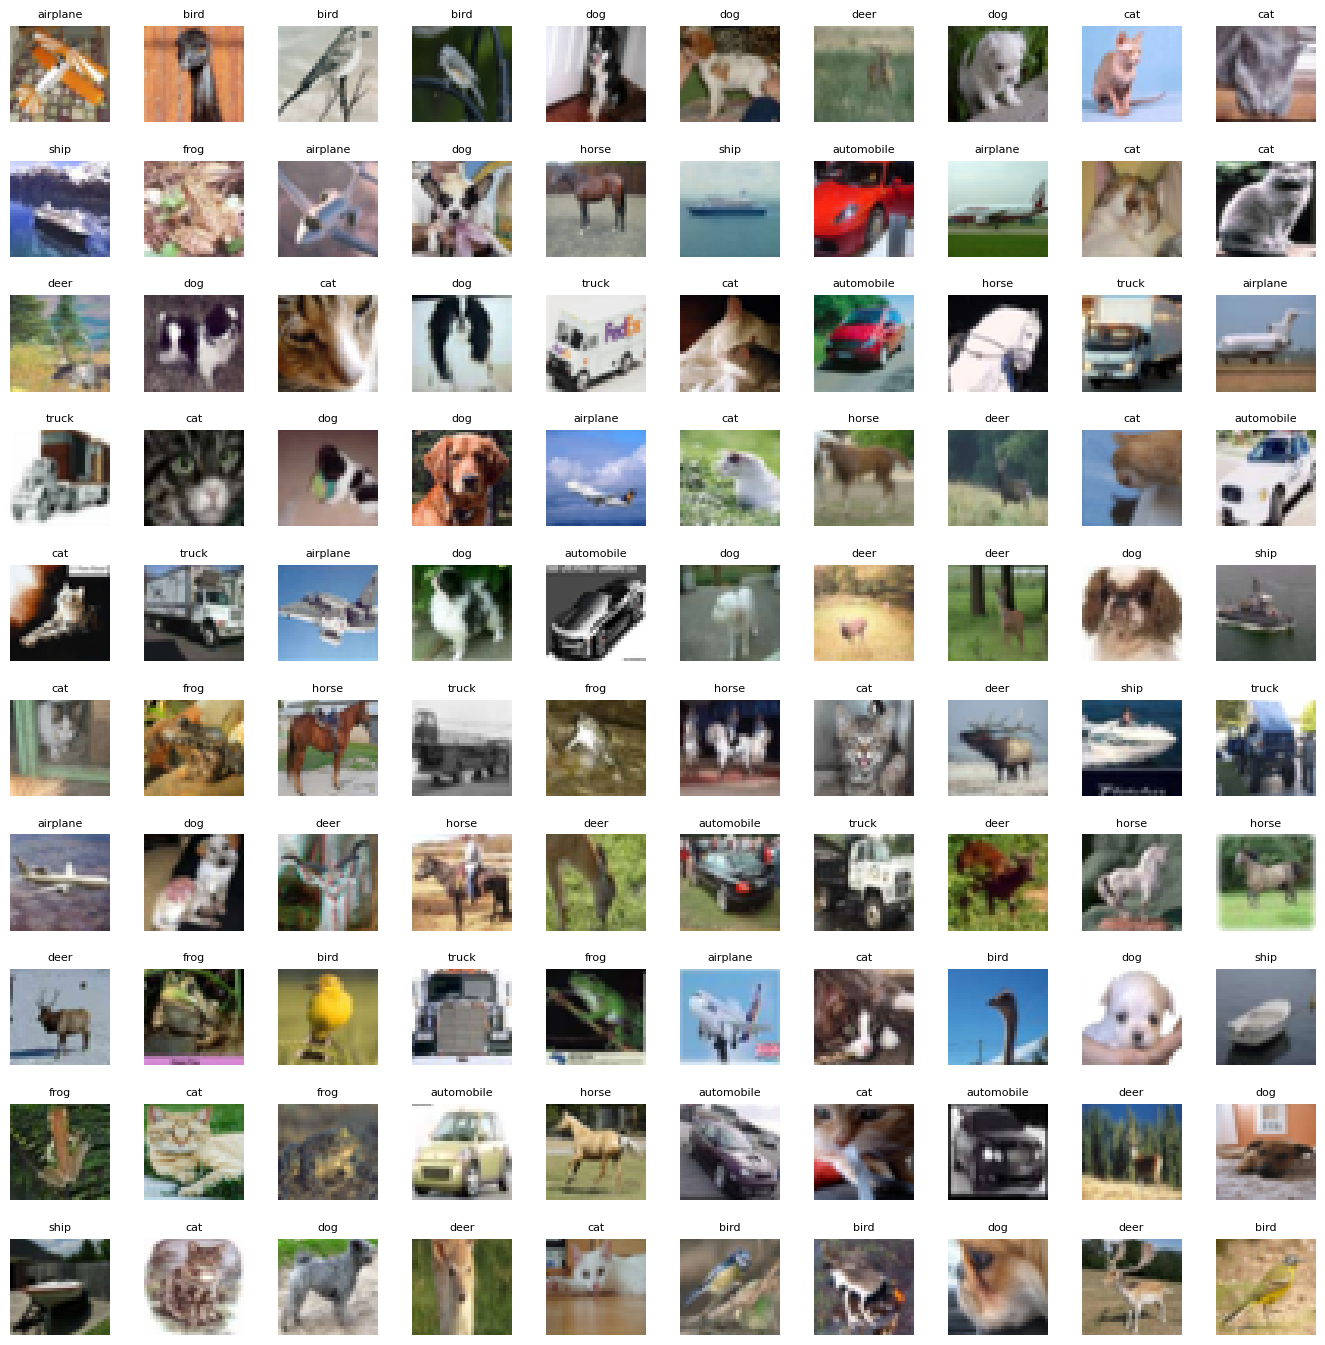

In [4]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

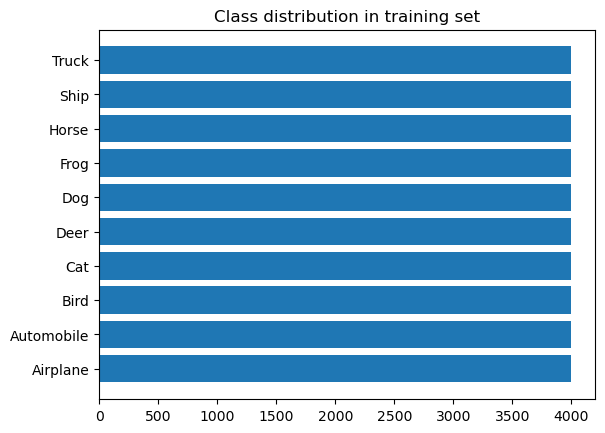

In [5]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

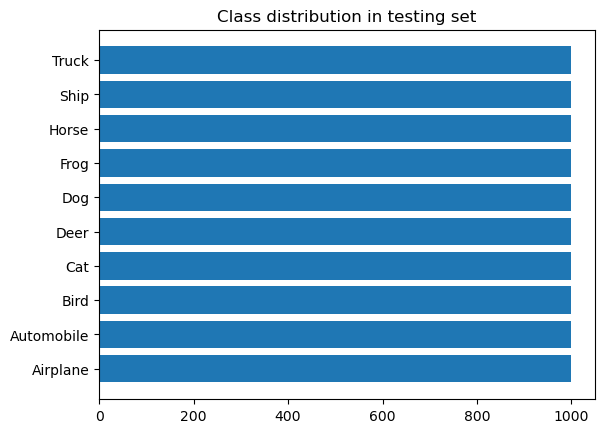

In [6]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

Text(0.5, 1.0, 'Class distribution in validation set')

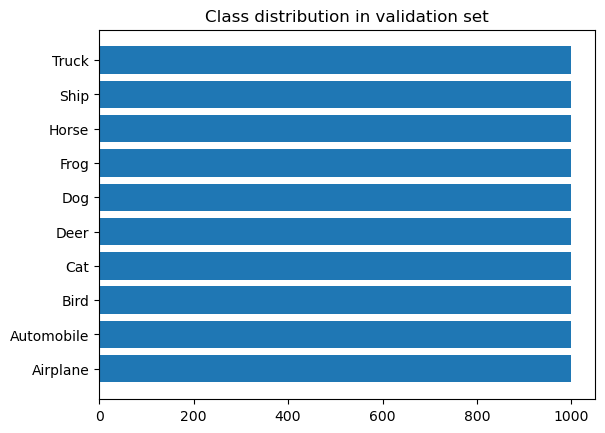

In [7]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_val, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in validation set')

#### The classes are equally distributes into train, test and val

# 🔄 Data Preprocessing

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

X_train = np.transpose(X_train, (0, 3, 1, 2))  
X_val = np.transpose(X_val, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

train_transform = transforms.Compose([
    transforms.ToTensor(),  # Ensure the images are converted to float and scaled to [0, 1]
    transforms.RandomHorizontalFlip(),  # Flip horizontally
    transforms.RandomRotation(10),      # Decrease rotation angle to 10
    transforms.RandomResizedCrop(32),   # Random crop to 32x32
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])  # Normalize pixel values
])

# Apply similar transformations for val and test sets
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

# If X_train, X_val, X_test are numpy arrays, convert them into datasets
train_data = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
val_data = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())
test_data = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long())

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [9]:
# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU(inplace=True)

        self.fc1 = nn.Linear(512 * 2 * 2, 4096)
        self.bn_fc1 = nn.BatchNorm1d(4096)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(4096, 2048)
        self.bn_fc2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(2048, 1024)
        self.bn_fc3 = nn.BatchNorm1d(1024)
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(1024, 512)
        self.bn_fc4 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.2)
        self.fc5 = nn.Linear(512, 256)
        self.bn_fc5 = nn.BatchNorm1d(256)
        self.dropout5 = nn.Dropout(0.2)
        self.fc6 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.relu(self.bn7(self.conv7(x)))
        x = self.relu(self.bn8(self.conv8(x)))

        x = x.view(-1, 512 * 2 * 2)

        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.relu(self.bn_fc3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.relu(self.bn_fc4(self.fc4(x)))
        x = self.dropout4(x)
        x = self.relu(self.bn_fc5(self.fc5(x)))
        x = self.dropout5(x)
        x = self.fc6(x)
        return x

In [10]:
model = CNN()
# Access weights and biases
weights_conv1 = model.conv1.weight
biases_fc2 = model.fc2.bias

for name, param in model.named_parameters():
    if 'weight' in name:
        print(f"{name} - shape: {param.shape}")

conv1.weight - shape: torch.Size([64, 3, 3, 3])
bn1.weight - shape: torch.Size([64])
conv2.weight - shape: torch.Size([128, 64, 3, 3])
bn2.weight - shape: torch.Size([128])
conv3.weight - shape: torch.Size([256, 128, 3, 3])
bn3.weight - shape: torch.Size([256])
conv4.weight - shape: torch.Size([512, 256, 3, 3])
bn4.weight - shape: torch.Size([512])
conv5.weight - shape: torch.Size([512, 512, 3, 3])
bn5.weight - shape: torch.Size([512])
conv6.weight - shape: torch.Size([512, 512, 3, 3])
bn6.weight - shape: torch.Size([512])
conv7.weight - shape: torch.Size([512, 512, 3, 3])
bn7.weight - shape: torch.Size([512])
conv8.weight - shape: torch.Size([512, 512, 3, 3])
bn8.weight - shape: torch.Size([512])
fc1.weight - shape: torch.Size([4096, 2048])
bn_fc1.weight - shape: torch.Size([4096])
fc2.weight - shape: torch.Size([2048, 4096])
bn_fc2.weight - shape: torch.Size([2048])
fc3.weight - shape: torch.Size([1024, 2048])
bn_fc3.weight - shape: torch.Size([1024])
fc4.weight - shape: torch.Size([

## ✅ Training & Validation Loop Setup

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and move it to the correct device
model = CNN().to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

print(f"Model is on device: {next(model.parameters()).device}")

Model is on device: cuda:0


In [12]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(epoch, model, save_dir="/home/lab-01/Desktop/ADVST_ANCHAL_GUPTA/AG-1/Histogram"):
    # Ensure the model is on CPU for plotting (if it's on GPU)
    for name, param in model.named_parameters():
        if 'weight' in name or 'bias' in name:
            # Extract layer name and parameter type (weight or bias)
            layer_name = name.split('.')[0]  # Extract the layer name, e.g., 'conv1', 'conv2', 'fc1'
            param_type = 'weights' if 'weight' in name else 'biases'
            
            # Create the directory for each layer and parameter type (weights/biases)
            subfolder_path = os.path.join(save_dir, layer_name, param_type)
            os.makedirs(subfolder_path, exist_ok=True)

            # Move parameters to CPU if they are on GPU
            param_cpu = param.detach().cpu()

            # Plot and save the histograms
            plt.figure(figsize=(10, 5))
            color = 'g' if param_type == 'weights' else 'r'
            plt.hist(param_cpu.numpy().flatten(), bins=10, density=True, alpha=0.6, color=color)
            plt.title(f'{param_type[:-1].capitalize()} Distribution - {name} (Epoch {epoch})')
            plt.xlabel('Value')
            plt.ylabel('Density')
            plt.grid(True)

            # Create filename based on the layer and epoch
            param_label = name.replace('.', '_')  # Replace '.' with '_' in parameter names (e.g., 'conv1.weight')
            filename = f"{param_label}_epoch{epoch}.png"
            
            # Save the plot in the correct subfolder
            plt.savefig(os.path.join(subfolder_path, filename))
            plt.close()


## Step-by-Step Global Weight & Bias Tracking (per epoch)

In [13]:
import torch
import os
import matplotlib.pyplot as plt

def track_weights_biases_hist(model, epoch, output_dir="Global Weight & Bias", bins=10, color_weights='navy', color_biases='darkorange', edge_color='black'):
    # Create the necessary subdirectories for global parameters
    global_params_dir = os.path.join(output_dir, "global_parameters")
    os.makedirs(global_params_dir, exist_ok=True)

    # Subfolders for weights and biases
    weights_dir = os.path.join(global_params_dir, "weights")
    biases_dir = os.path.join(global_params_dir, "biases")
    os.makedirs(weights_dir, exist_ok=True)
    os.makedirs(biases_dir, exist_ok=True)

    # Lists to collect weight and bias parameters
    weight_list = []
    bias_list = []

    # Iterate through the model's parameters and separate weights and biases
    for name, param in model.named_parameters():
        if 'weight' in name:
            weight_list.append(param.view(-1))  # Flatten and append the weights
        elif 'bias' in name:
            bias_list.append(param.view(-1))  # Flatten and append the biases

    # Check if there are no weights or biases in the model
    if not weight_list:
        print(f"Warning: No weights found for model at epoch {epoch}")
    if not bias_list:
        print(f"Warning: No biases found for model at epoch {epoch}")

    # Convert to single flat tensors and detach from the computation graph
    all_weights = torch.cat(weight_list).detach().cpu().numpy() if weight_list else None
    all_biases = torch.cat(bias_list).detach().cpu().numpy() if bias_list else None

    # Plot and save the weights histogram if weights exist
    if all_weights is not None:
        plt.figure(figsize=(6, 4))
        plt.hist(all_weights, bins=bins, density=True, color=color_weights, edgecolor=edge_color)
        plt.title(f"Weights - Epoch {epoch}")
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(weights_dir, f"weights_epoch_{epoch}.png"))
        plt.close()

    # Plot and save the biases histogram if biases exist
    if all_biases is not None:
        plt.figure(figsize=(6, 4))
        plt.hist(all_biases, bins=bins, density=True, color=color_biases, edgecolor=edge_color)
        plt.title(f"Biases - Epoch {epoch}")
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(biases_dir, f"biases_epoch_{epoch}.png"))
        plt.close()

In [14]:
import torch
import os
from tqdm import tqdm

# Directory to save all checkpoints
save_dir = 'training_checkpoints'
os.makedirs(save_dir, exist_ok=True)

num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    # ✅ Generate and save histograms for analysis
    plot_histogram(epoch, model)
    track_weights_biases_hist(model, epoch)

    # ✅ Save a single checkpoint file for the entire epoch
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses[-1],
        'train_accuracy': train_accuracies[-1],
        'val_loss': val_losses[-1],
        'val_accuracy': val_accuracies[-1]
    }

    checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth')
    torch.save(checkpoint, checkpoint_path)

# Save final model
torch.save(model.state_dict(), os.path.join(save_dir, 'final_model.pth'))

Epoch 1/50: 100%|█████████████████████████████| 625/625 [00:06<00:00, 93.12it/s]


Epoch 1/50, Train Loss: 1.6564, Train Accuracy: 36.16%, Val Loss: 1.3817, Val Accuracy: 48.31%


Epoch 2/50: 100%|█████████████████████████████| 625/625 [00:06<00:00, 97.84it/s]


Epoch 2/50, Train Loss: 1.2556, Train Accuracy: 54.05%, Val Loss: 1.6791, Val Accuracy: 43.49%


Epoch 3/50: 100%|████████████████████████████| 625/625 [00:05<00:00, 109.13it/s]


Epoch 3/50, Train Loss: 1.0169, Train Accuracy: 63.98%, Val Loss: 1.0039, Val Accuracy: 65.02%


Epoch 4/50: 100%|████████████████████████████| 625/625 [00:03<00:00, 173.24it/s]


Epoch 4/50, Train Loss: 0.8581, Train Accuracy: 69.86%, Val Loss: 0.9602, Val Accuracy: 66.68%


Epoch 5/50: 100%|████████████████████████████| 625/625 [00:05<00:00, 117.82it/s]


Epoch 5/50, Train Loss: 0.7401, Train Accuracy: 74.14%, Val Loss: 0.9089, Val Accuracy: 68.57%


Epoch 6/50: 100%|████████████████████████████| 625/625 [00:03<00:00, 171.19it/s]


Epoch 6/50, Train Loss: 0.6506, Train Accuracy: 77.36%, Val Loss: 1.0505, Val Accuracy: 65.49%


Epoch 7/50: 100%|████████████████████████████| 625/625 [00:03<00:00, 156.96it/s]


Epoch 7/50, Train Loss: 0.5601, Train Accuracy: 80.37%, Val Loss: 0.9384, Val Accuracy: 68.84%


Epoch 8/50: 100%|████████████████████████████| 625/625 [00:03<00:00, 173.65it/s]


Epoch 8/50, Train Loss: 0.4769, Train Accuracy: 83.49%, Val Loss: 0.9818, Val Accuracy: 70.70%


Epoch 9/50: 100%|████████████████████████████| 625/625 [00:03<00:00, 167.32it/s]


Epoch 9/50, Train Loss: 0.4032, Train Accuracy: 86.06%, Val Loss: 1.0147, Val Accuracy: 70.87%


Epoch 10/50: 100%|███████████████████████████| 625/625 [00:03<00:00, 175.47it/s]


Epoch 10/50, Train Loss: 0.3456, Train Accuracy: 88.10%, Val Loss: 0.8301, Val Accuracy: 74.45%


Epoch 11/50: 100%|███████████████████████████| 625/625 [00:04<00:00, 153.59it/s]


Epoch 11/50, Train Loss: 0.2835, Train Accuracy: 90.22%, Val Loss: 0.9742, Val Accuracy: 72.62%


Epoch 12/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 99.40it/s]


Epoch 12/50, Train Loss: 0.2480, Train Accuracy: 91.62%, Val Loss: 1.0139, Val Accuracy: 71.77%


Epoch 13/50: 100%|███████████████████████████| 625/625 [00:05<00:00, 122.41it/s]


Epoch 13/50, Train Loss: 0.2065, Train Accuracy: 93.07%, Val Loss: 1.0132, Val Accuracy: 73.67%


Epoch 14/50: 100%|███████████████████████████| 625/625 [00:03<00:00, 169.39it/s]


Epoch 14/50, Train Loss: 0.1758, Train Accuracy: 93.98%, Val Loss: 0.9323, Val Accuracy: 75.20%


Epoch 15/50: 100%|███████████████████████████| 625/625 [00:06<00:00, 102.21it/s]


Epoch 15/50, Train Loss: 0.1531, Train Accuracy: 94.79%, Val Loss: 1.0554, Val Accuracy: 73.69%


Epoch 16/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 97.74it/s]


Epoch 16/50, Train Loss: 0.1350, Train Accuracy: 95.37%, Val Loss: 1.0643, Val Accuracy: 74.18%


Epoch 17/50: 100%|███████████████████████████| 625/625 [00:04<00:00, 156.13it/s]


Epoch 17/50, Train Loss: 0.1203, Train Accuracy: 95.98%, Val Loss: 1.0639, Val Accuracy: 74.42%


Epoch 18/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 96.97it/s]


Epoch 18/50, Train Loss: 0.0992, Train Accuracy: 96.67%, Val Loss: 1.0109, Val Accuracy: 76.37%


Epoch 19/50: 100%|███████████████████████████| 625/625 [00:03<00:00, 173.82it/s]


Epoch 19/50, Train Loss: 0.0940, Train Accuracy: 96.86%, Val Loss: 1.0466, Val Accuracy: 76.35%


Epoch 20/50: 100%|███████████████████████████| 625/625 [00:03<00:00, 167.95it/s]


Epoch 20/50, Train Loss: 0.0823, Train Accuracy: 97.20%, Val Loss: 1.1169, Val Accuracy: 75.38%


Epoch 21/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 99.61it/s]


Epoch 21/50, Train Loss: 0.0651, Train Accuracy: 97.84%, Val Loss: 1.0238, Val Accuracy: 77.51%


Epoch 22/50: 100%|███████████████████████████| 625/625 [00:06<00:00, 101.51it/s]


Epoch 22/50, Train Loss: 0.0681, Train Accuracy: 97.67%, Val Loss: 1.2905, Val Accuracy: 74.18%


Epoch 23/50: 100%|███████████████████████████| 625/625 [00:03<00:00, 174.48it/s]


Epoch 23/50, Train Loss: 0.0576, Train Accuracy: 98.11%, Val Loss: 1.0926, Val Accuracy: 76.16%


Epoch 24/50: 100%|███████████████████████████| 625/625 [00:03<00:00, 159.32it/s]


Epoch 24/50, Train Loss: 0.0455, Train Accuracy: 98.54%, Val Loss: 1.2210, Val Accuracy: 75.38%


Epoch 25/50: 100%|███████████████████████████| 625/625 [00:04<00:00, 140.40it/s]


Epoch 25/50, Train Loss: 0.0579, Train Accuracy: 98.04%, Val Loss: 1.1425, Val Accuracy: 76.26%


Epoch 26/50: 100%|███████████████████████████| 625/625 [00:04<00:00, 151.26it/s]


Epoch 26/50, Train Loss: 0.0411, Train Accuracy: 98.68%, Val Loss: 1.1145, Val Accuracy: 77.65%


Epoch 27/50: 100%|███████████████████████████| 625/625 [00:03<00:00, 161.71it/s]


Epoch 27/50, Train Loss: 0.0424, Train Accuracy: 98.61%, Val Loss: 1.0913, Val Accuracy: 78.08%


Epoch 28/50: 100%|███████████████████████████| 625/625 [00:03<00:00, 162.89it/s]


Epoch 28/50, Train Loss: 0.0408, Train Accuracy: 98.64%, Val Loss: 1.0963, Val Accuracy: 77.92%


Epoch 29/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 98.70it/s]


Epoch 29/50, Train Loss: 0.0364, Train Accuracy: 98.81%, Val Loss: 1.1683, Val Accuracy: 77.22%


Epoch 30/50: 100%|███████████████████████████| 625/625 [00:06<00:00, 102.76it/s]


Epoch 30/50, Train Loss: 0.0343, Train Accuracy: 98.88%, Val Loss: 1.1401, Val Accuracy: 77.56%


Epoch 31/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 98.49it/s]


Epoch 31/50, Train Loss: 0.0320, Train Accuracy: 98.95%, Val Loss: 1.3095, Val Accuracy: 75.47%


Epoch 32/50: 100%|███████████████████████████| 625/625 [00:05<00:00, 105.79it/s]


Epoch 32/50, Train Loss: 0.0294, Train Accuracy: 98.96%, Val Loss: 1.1871, Val Accuracy: 77.33%


Epoch 33/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 98.45it/s]


Epoch 33/50, Train Loss: 0.0316, Train Accuracy: 98.99%, Val Loss: 1.1713, Val Accuracy: 77.32%


Epoch 34/50: 100%|███████████████████████████| 625/625 [00:03<00:00, 174.68it/s]


Epoch 34/50, Train Loss: 0.0279, Train Accuracy: 99.06%, Val Loss: 1.1713, Val Accuracy: 77.82%


Epoch 35/50: 100%|███████████████████████████| 625/625 [00:03<00:00, 174.00it/s]


Epoch 35/50, Train Loss: 0.0270, Train Accuracy: 99.10%, Val Loss: 1.2938, Val Accuracy: 76.58%


Epoch 36/50: 100%|███████████████████████████| 625/625 [00:06<00:00, 100.26it/s]


Epoch 36/50, Train Loss: 0.0248, Train Accuracy: 99.21%, Val Loss: 1.1947, Val Accuracy: 78.53%


Epoch 37/50: 100%|███████████████████████████| 625/625 [00:05<00:00, 123.52it/s]


Epoch 37/50, Train Loss: 0.0246, Train Accuracy: 99.18%, Val Loss: 1.2790, Val Accuracy: 77.06%


Epoch 38/50: 100%|███████████████████████████| 625/625 [00:03<00:00, 172.61it/s]


Epoch 38/50, Train Loss: 0.0242, Train Accuracy: 99.23%, Val Loss: 1.1948, Val Accuracy: 77.84%


Epoch 39/50: 100%|███████████████████████████| 625/625 [00:05<00:00, 106.97it/s]


Epoch 39/50, Train Loss: 0.0177, Train Accuracy: 99.40%, Val Loss: 1.3972, Val Accuracy: 75.81%


Epoch 40/50: 100%|███████████████████████████| 625/625 [00:03<00:00, 179.42it/s]


Epoch 40/50, Train Loss: 0.0245, Train Accuracy: 99.25%, Val Loss: 1.2001, Val Accuracy: 77.98%


Epoch 41/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 98.38it/s]


Epoch 41/50, Train Loss: 0.0168, Train Accuracy: 99.45%, Val Loss: 1.2193, Val Accuracy: 78.39%


Epoch 42/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 97.99it/s]


Epoch 42/50, Train Loss: 0.0171, Train Accuracy: 99.42%, Val Loss: 1.2752, Val Accuracy: 76.87%


Epoch 43/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 98.18it/s]


Epoch 43/50, Train Loss: 0.0189, Train Accuracy: 99.38%, Val Loss: 1.2956, Val Accuracy: 77.04%


Epoch 44/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 97.85it/s]


Epoch 44/50, Train Loss: 0.0160, Train Accuracy: 99.48%, Val Loss: 1.2288, Val Accuracy: 77.83%


Epoch 45/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 98.67it/s]


Epoch 45/50, Train Loss: 0.0179, Train Accuracy: 99.44%, Val Loss: 1.1979, Val Accuracy: 78.64%


Epoch 46/50: 100%|███████████████████████████| 625/625 [00:04<00:00, 147.14it/s]


Epoch 46/50, Train Loss: 0.0165, Train Accuracy: 99.49%, Val Loss: 1.2575, Val Accuracy: 77.17%


Epoch 47/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 97.69it/s]


Epoch 47/50, Train Loss: 0.0149, Train Accuracy: 99.52%, Val Loss: 1.2046, Val Accuracy: 78.71%


Epoch 48/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 98.05it/s]


Epoch 48/50, Train Loss: 0.0114, Train Accuracy: 99.61%, Val Loss: 1.2742, Val Accuracy: 78.19%


Epoch 49/50: 100%|████████████████████████████| 625/625 [00:06<00:00, 99.32it/s]


Epoch 49/50, Train Loss: 0.0169, Train Accuracy: 99.44%, Val Loss: 1.2191, Val Accuracy: 78.40%


Epoch 50/50: 100%|███████████████████████████| 625/625 [00:05<00:00, 107.28it/s]


Epoch 50/50, Train Loss: 0.0139, Train Accuracy: 99.55%, Val Loss: 1.2920, Val Accuracy: 77.73%


In [15]:
# After training is complete, evaluate on the test set
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():  # No need to compute gradients for testing
    for inputs, labels in test_loader:  # Assuming test_loader is your test dataset loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy and test loss
test_accuracy = 100 * correct / total
test_loss = test_loss / len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 1.3051, Test Accuracy: 77.41%


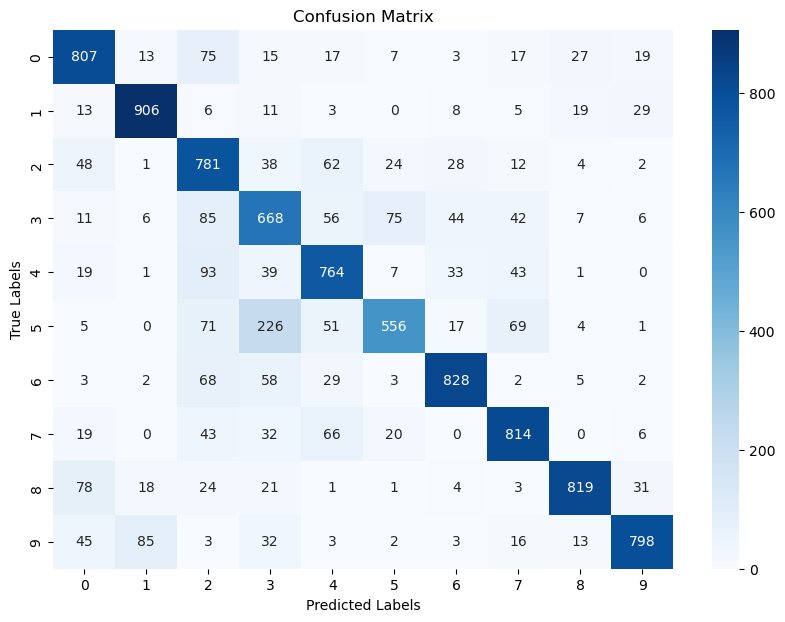

Confusion matrix plot saved at confusion_matrix_plots/confusion_matrix.png


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Assuming you have all_preds and all_labels already defined

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Set the directory where you want to save the plot
save_dir = 'confusion_matrix_plots'
os.makedirs(save_dir, exist_ok=True)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the plot as an image
confusion_matrix_filename = os.path.join(save_dir, 'confusion_matrix.png')
plt.savefig(confusion_matrix_filename)

# Show the plot
plt.show()

print(f"Confusion matrix plot saved at {confusion_matrix_filename}")

In [77]:
# After training loop and saving the model, you can print the metrics as follows:

# Print final training metrics (after all epochs)
final_train_loss = train_losses[-1]
final_train_accuracy = train_accuracies[-1]
print(f"Final Training Metrics: Loss = {final_train_loss:.4f}, Accuracy = {final_train_accuracy:.2f}%")

# Print final validation metrics (after all epochs)
final_val_loss = val_losses[-1]
final_val_accuracy = val_accuracies[-1]
print(f"Final Validation Metrics: Loss = {final_val_loss:.4f}, Accuracy = {final_val_accuracy:.2f}%")

# Test Loop - already provided in your code, print test metrics
test_accuracy = 100 * correct / total
final_test_loss = test_loss / len(test_loader)
print(f"Final Test Metrics: Loss = {final_test_loss:.4f}, Accuracy = {test_accuracy:.2f}%")

Final Training Metrics: Loss = 0.0139, Accuracy = 99.55%
Final Validation Metrics: Loss = 1.2920, Accuracy = 77.73%
Final Test Metrics: Loss = 0.0083, Accuracy = 77.41%


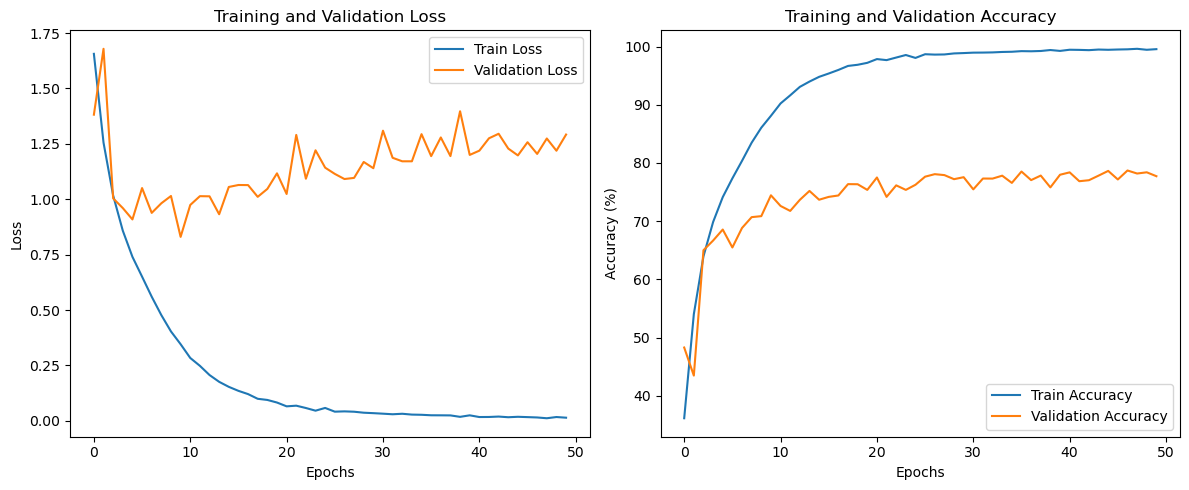

Loss and Accuracy plots saved at plots/loss_accuracy_plot.png


In [17]:
import matplotlib.pyplot as plt
import os

# Directory to save the plots
save_dir = 'plots'
os.makedirs(save_dir, exist_ok=True)

# Plotting Loss and Accuracy curves
# Plot Loss Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()

# Save the Loss and Accuracy plots
loss_accuracy_filename = os.path.join(save_dir, 'loss_accuracy_plot.png')
plt.savefig(loss_accuracy_filename)

# Optionally, display the plots
plt.show()

print(f"Loss and Accuracy plots saved at {loss_accuracy_filename}")

## ESD Analysis for All Layers in Final Model


🔍 Analyzing ESD for checkpoint: /home/lab-01/Desktop/ADVST_ANCHAL_GUPTA/AG-1/training_checkpoints/checkpoint_epoch_50.pth


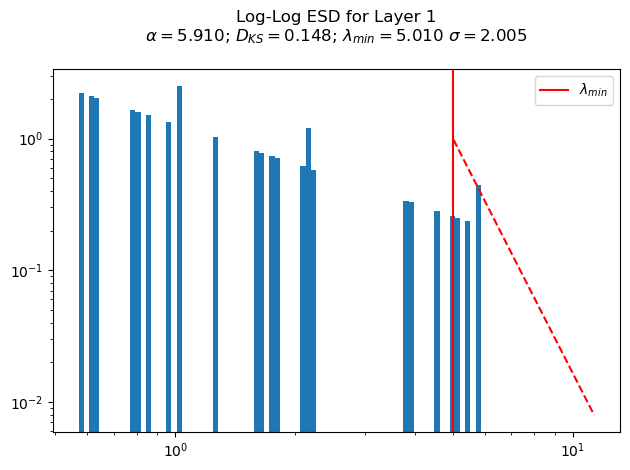

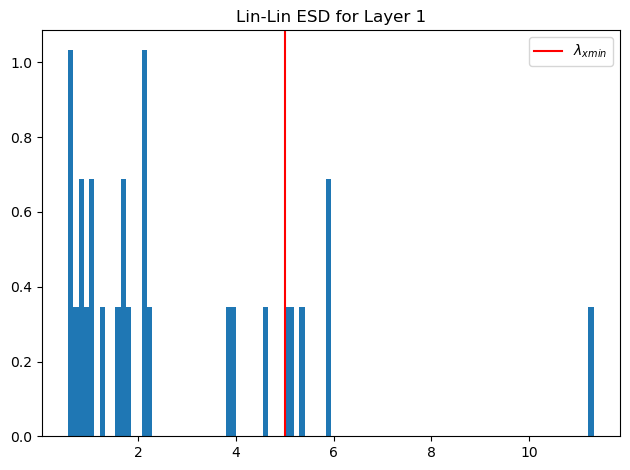

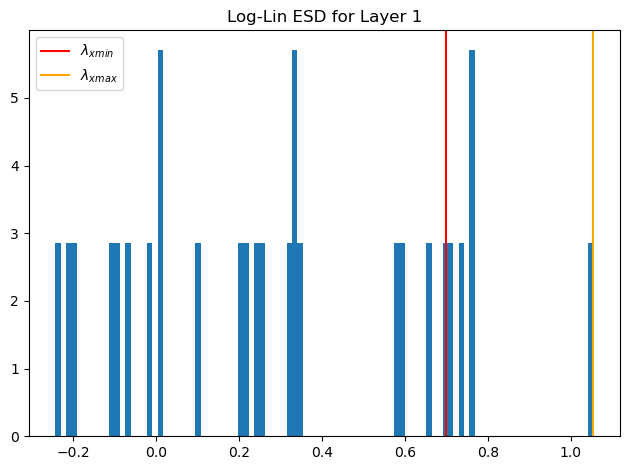

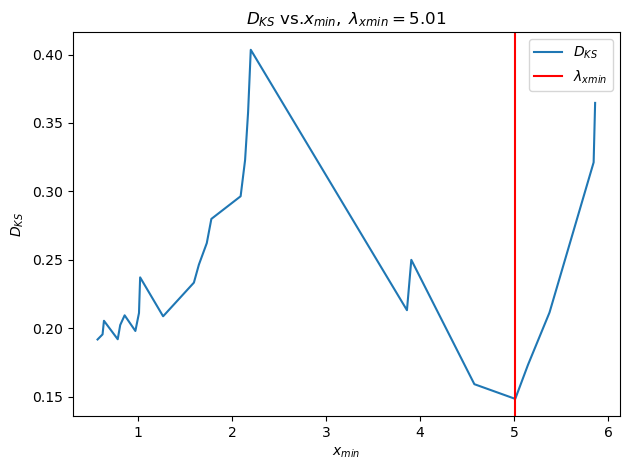

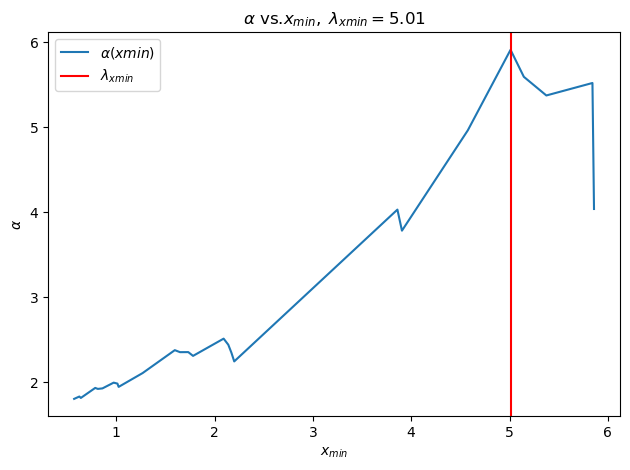

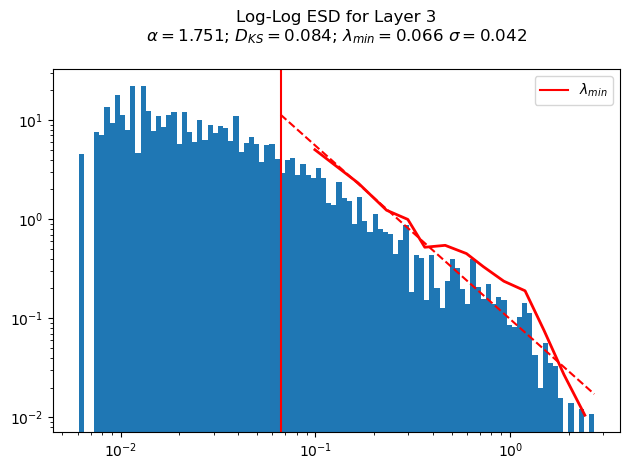

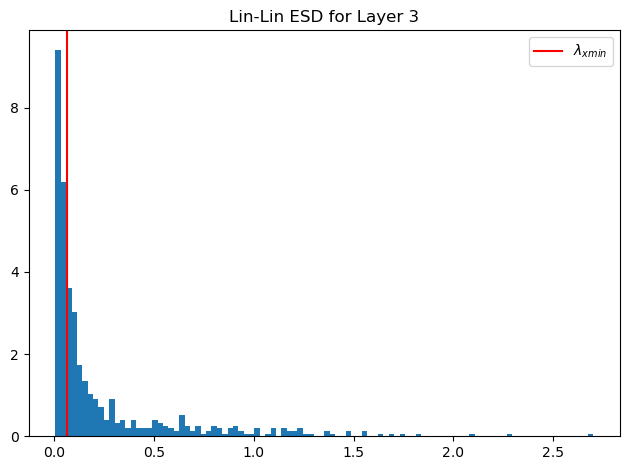

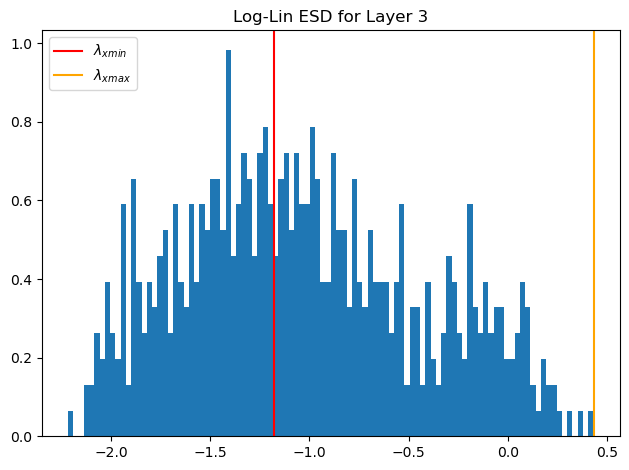

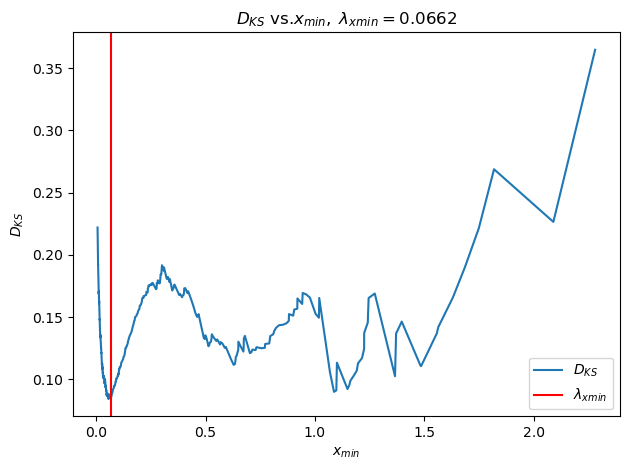

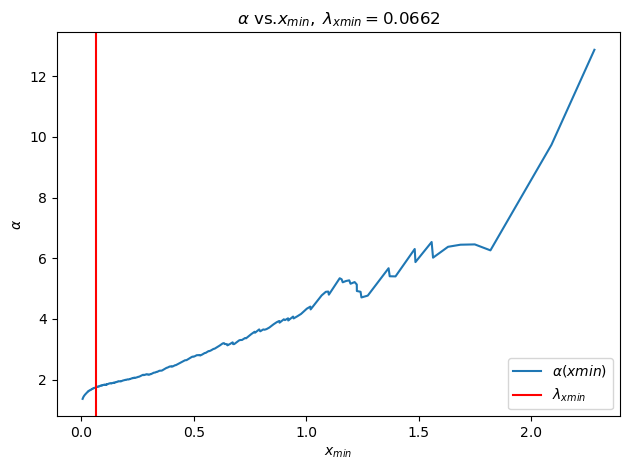

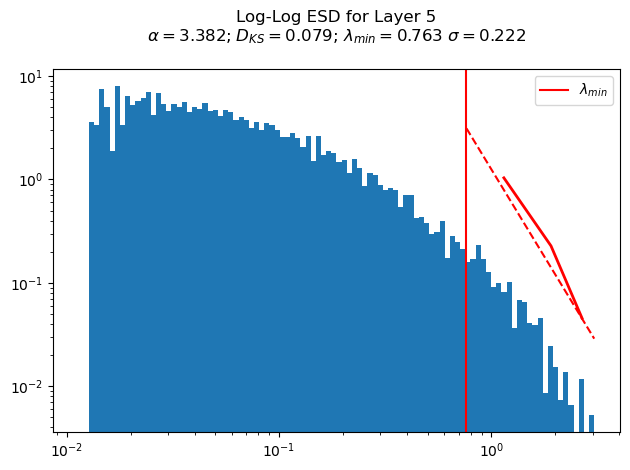

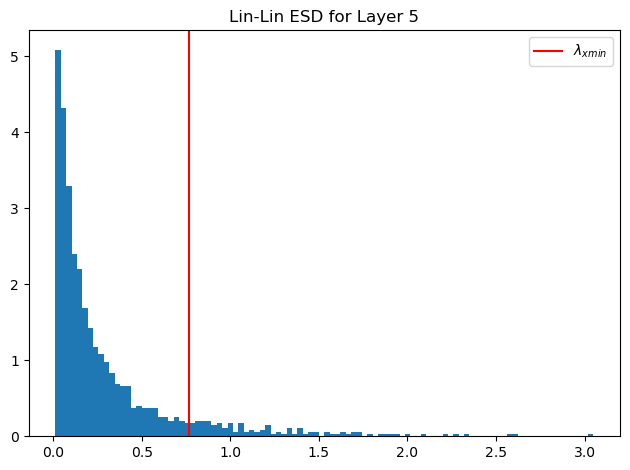

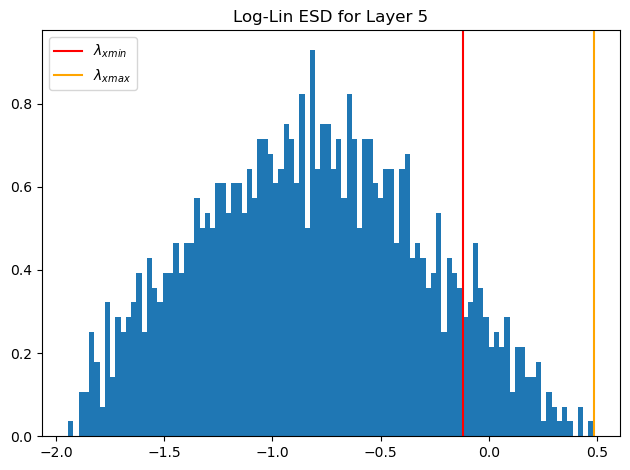

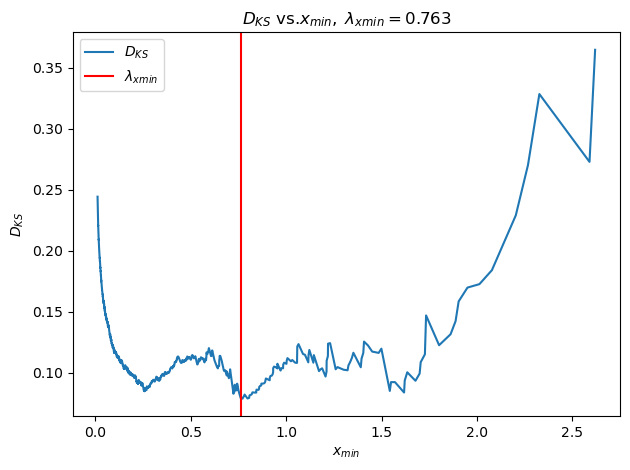

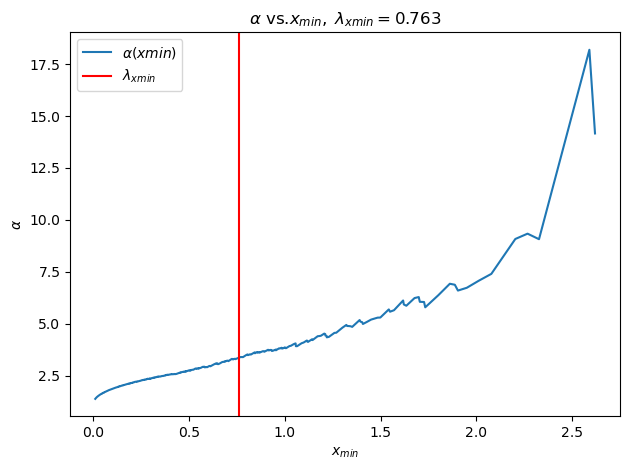

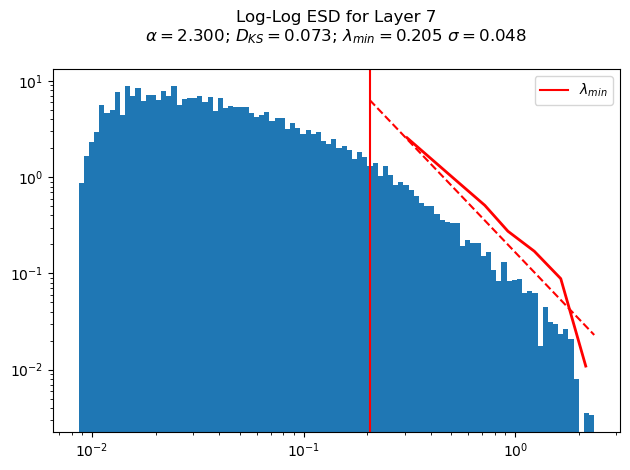

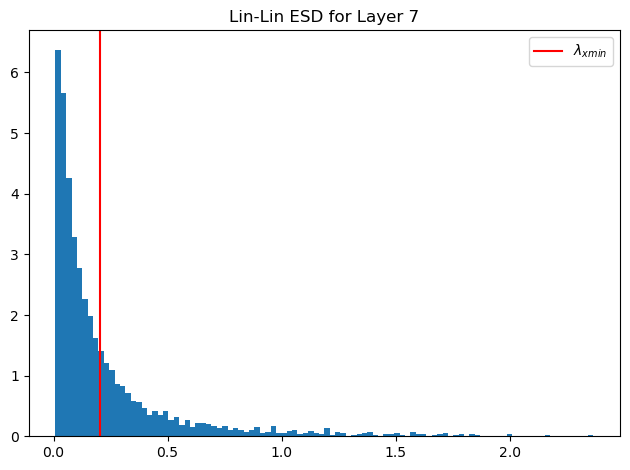

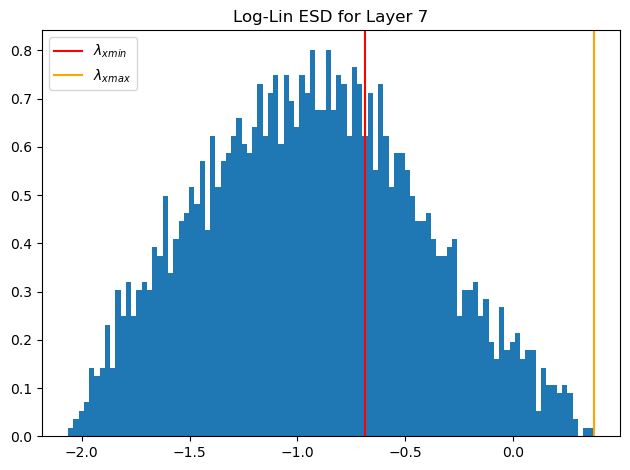

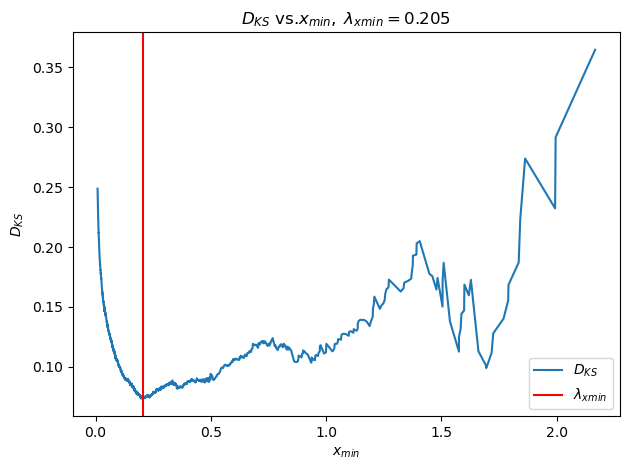

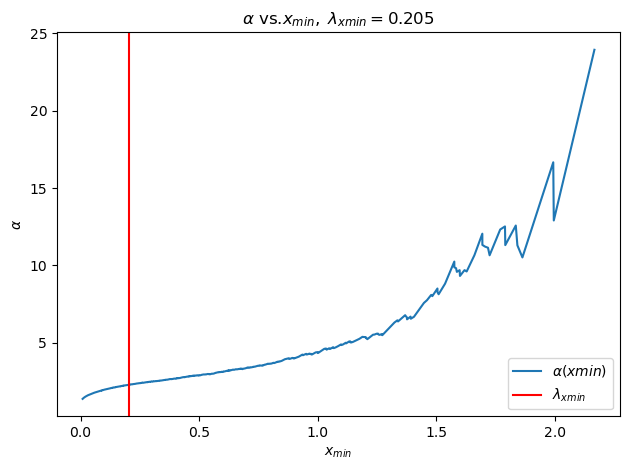

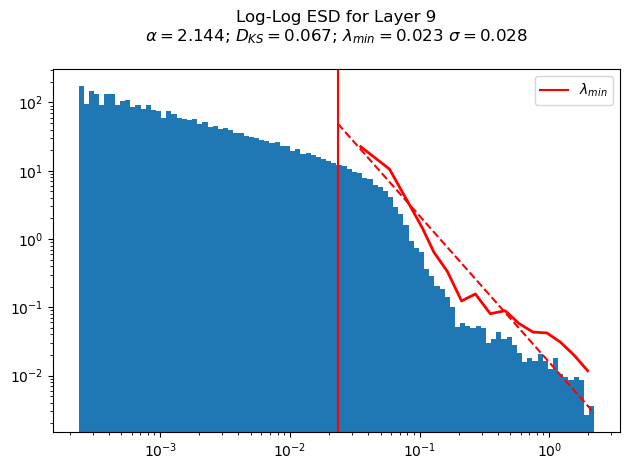

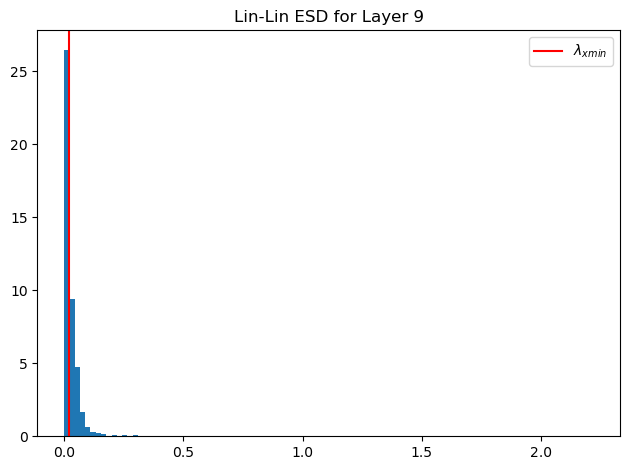

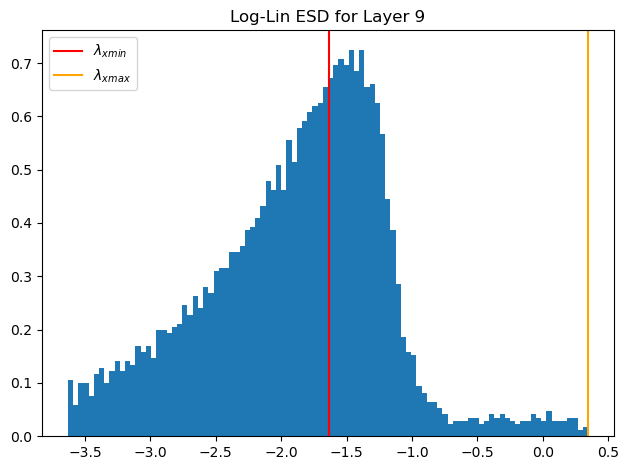

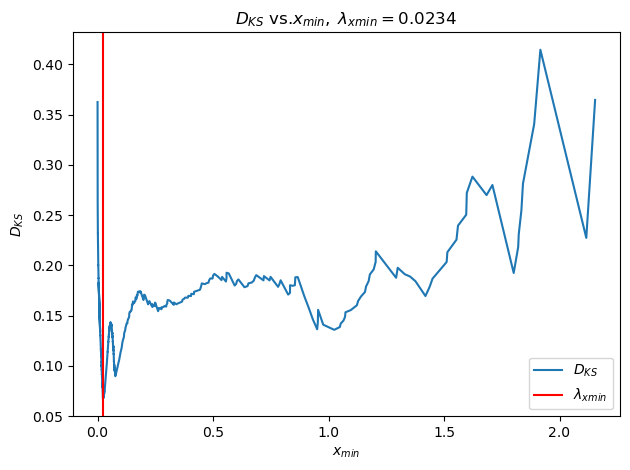

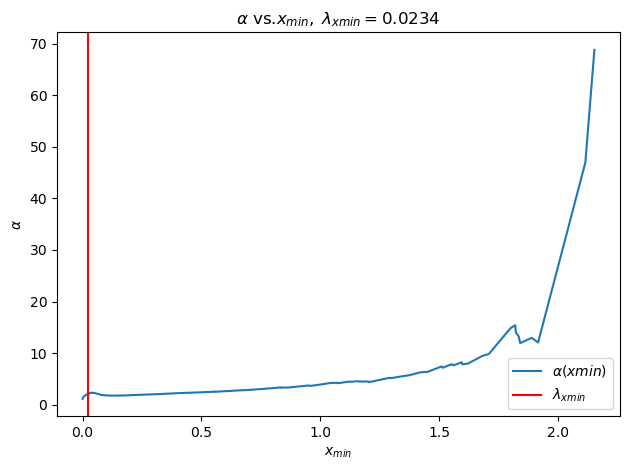

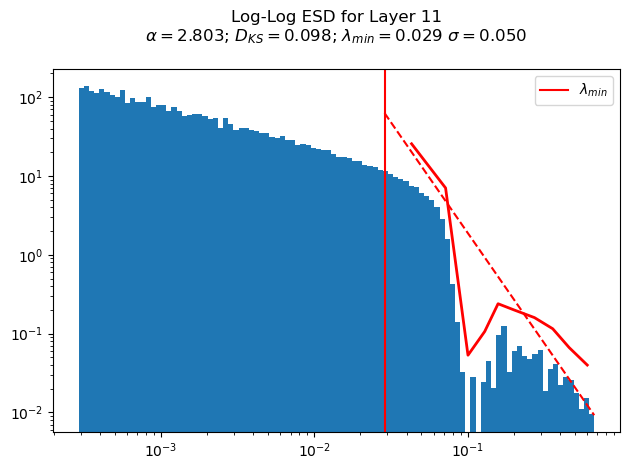

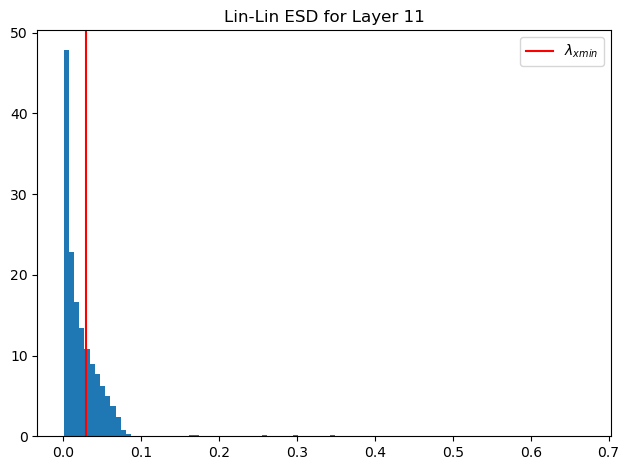

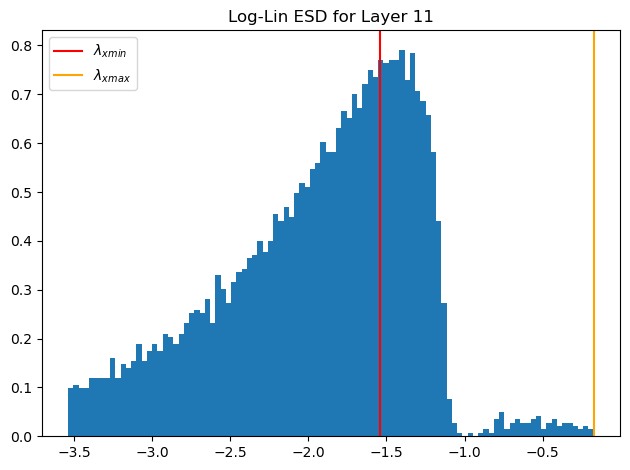

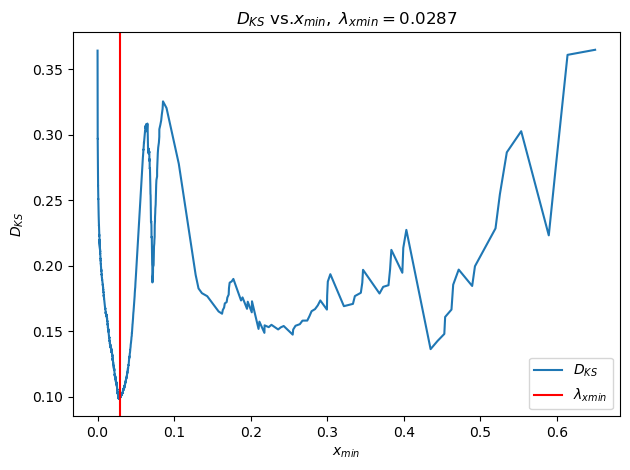

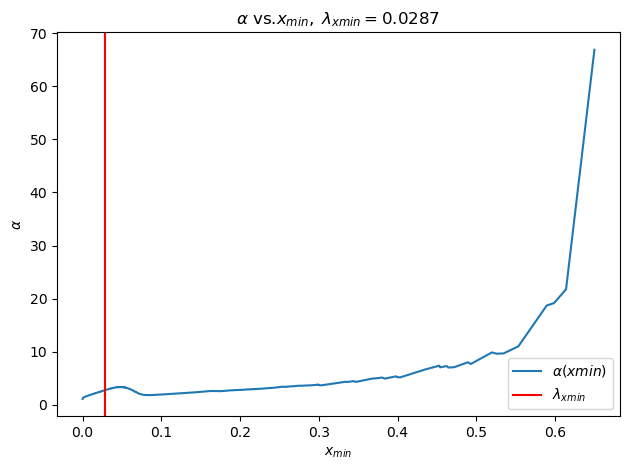

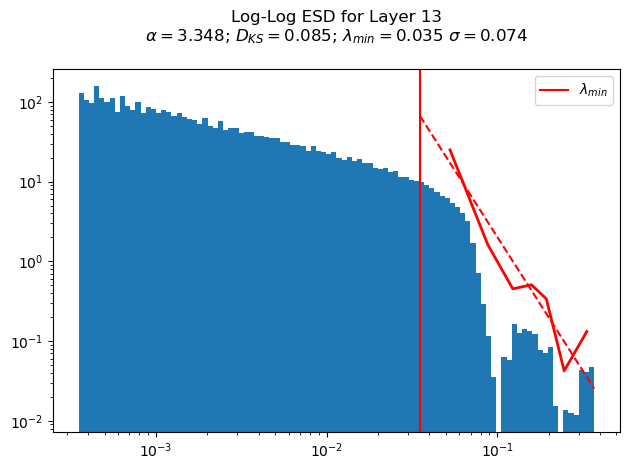

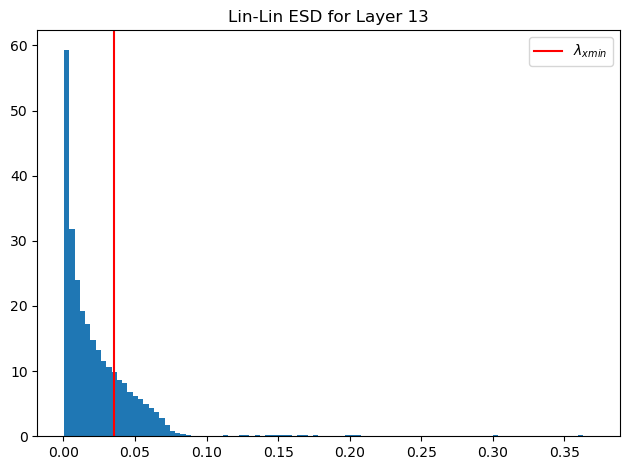

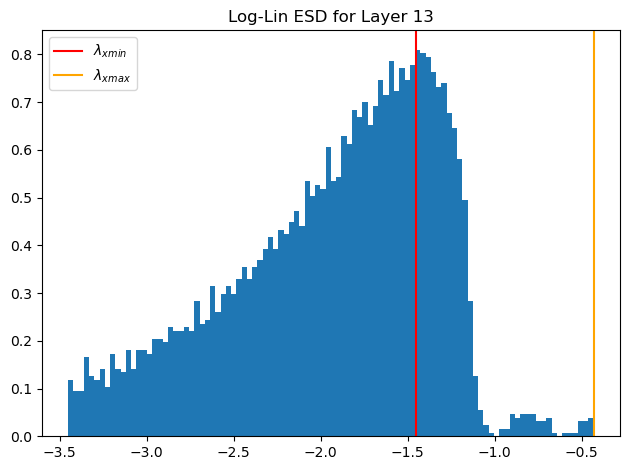

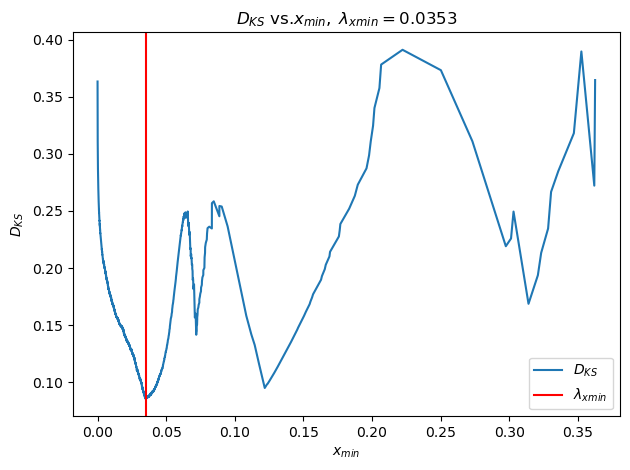

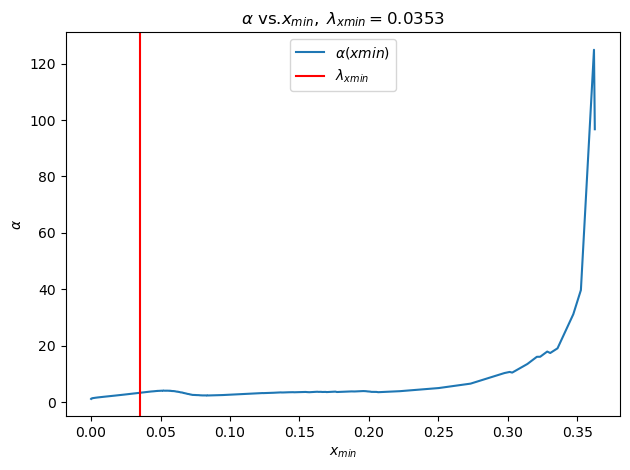

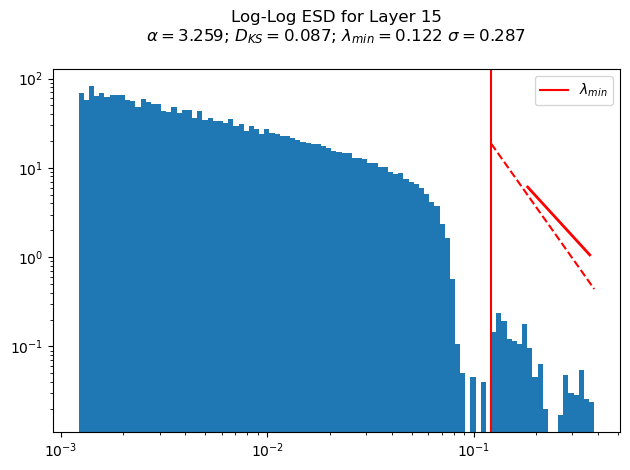

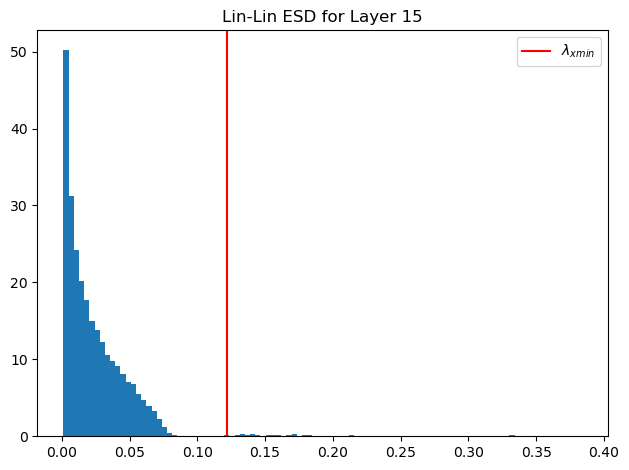

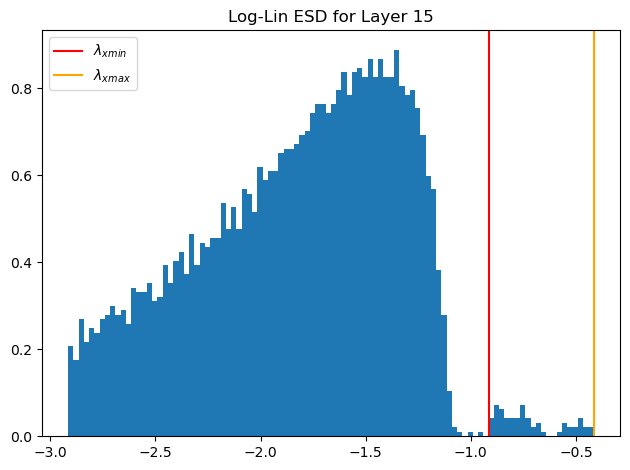

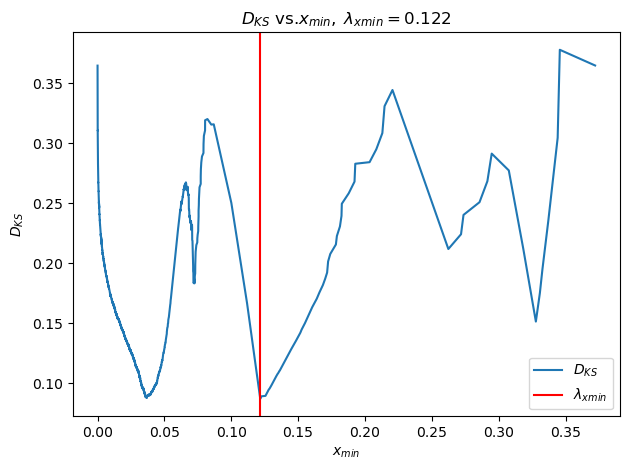

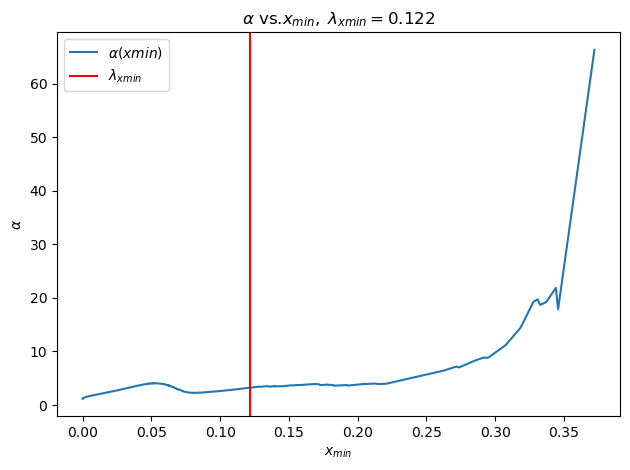

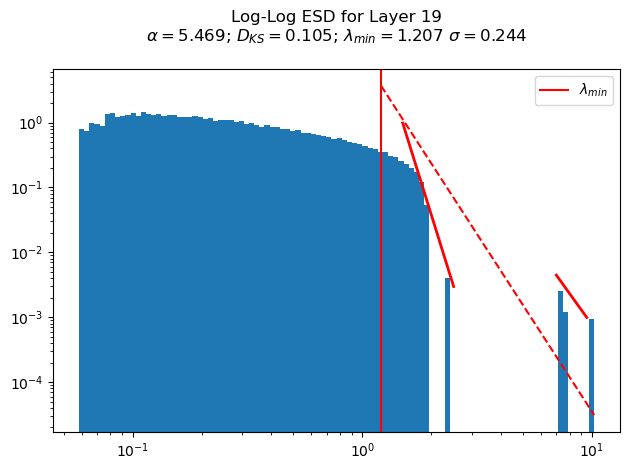

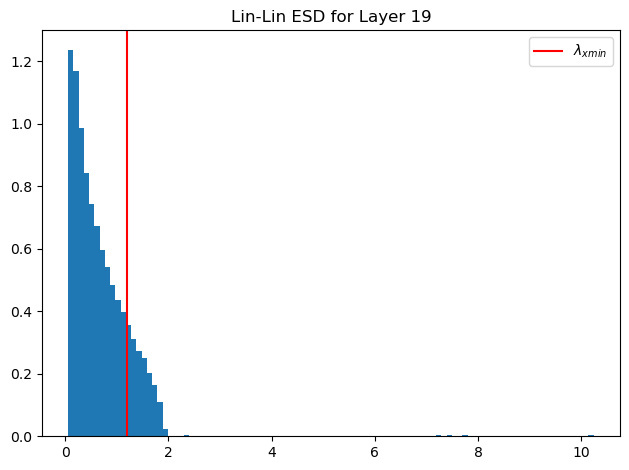

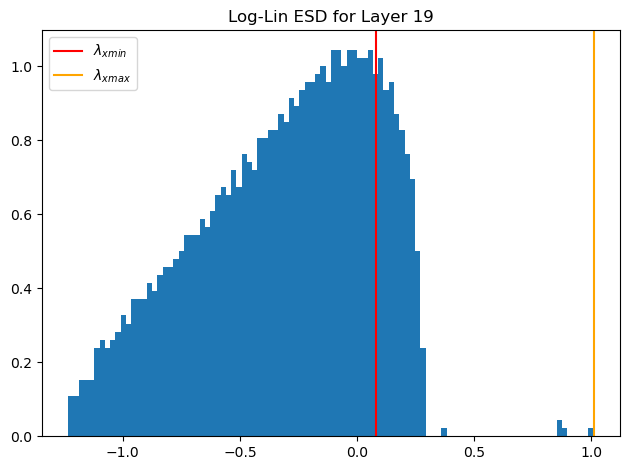

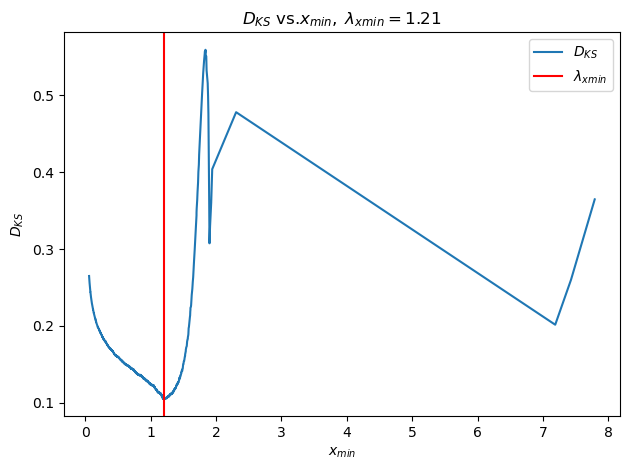

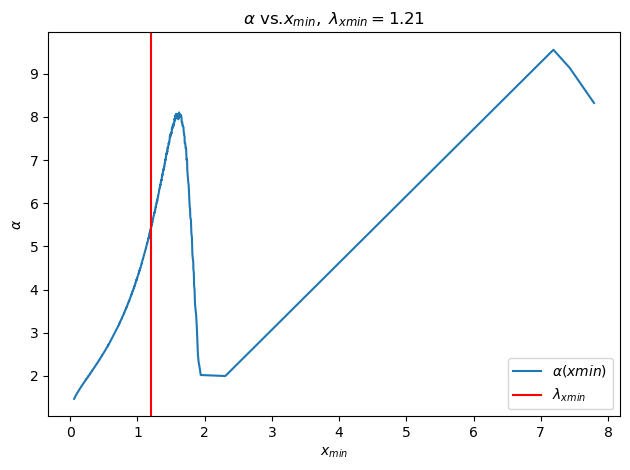

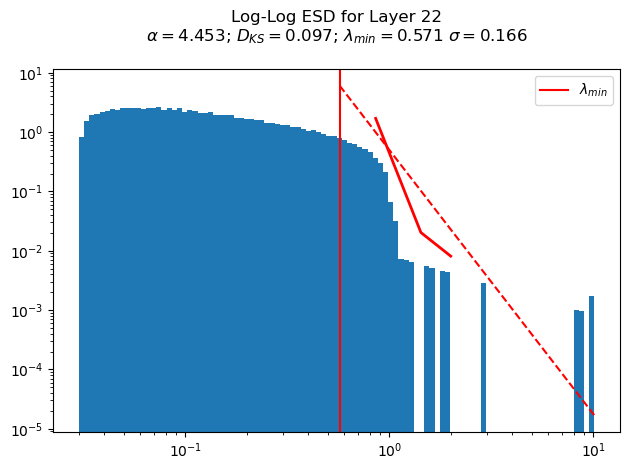

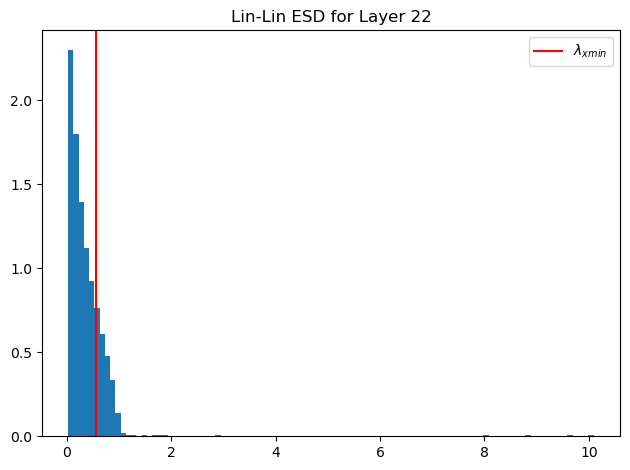

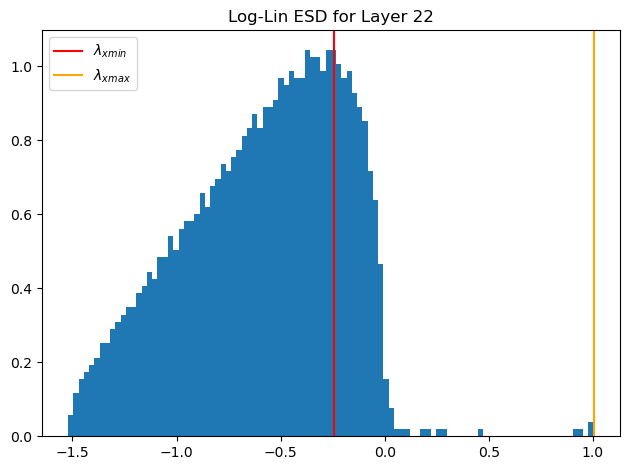

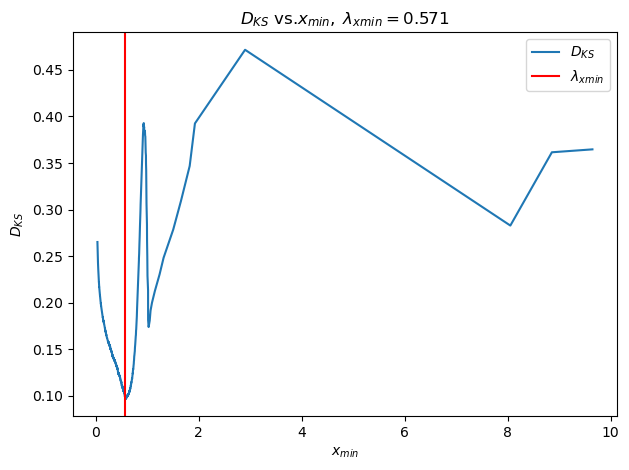

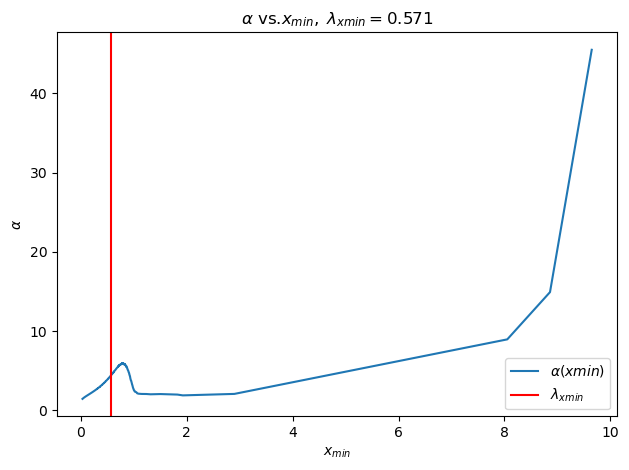

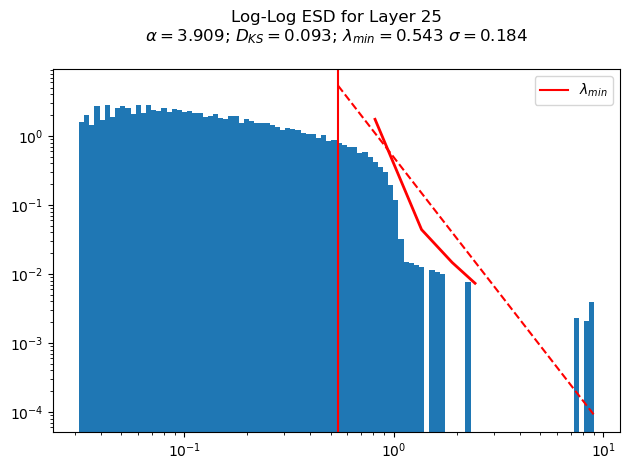

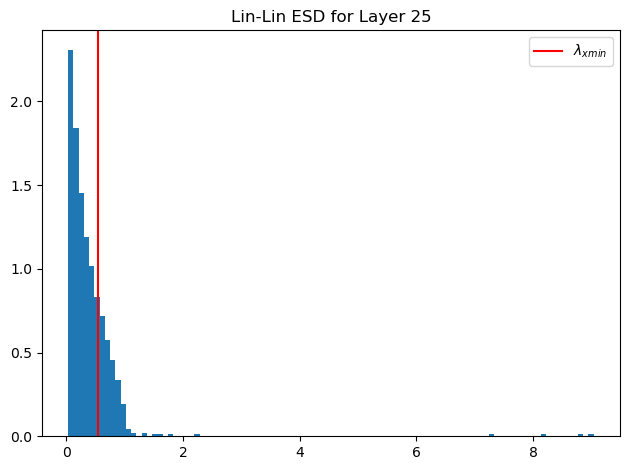

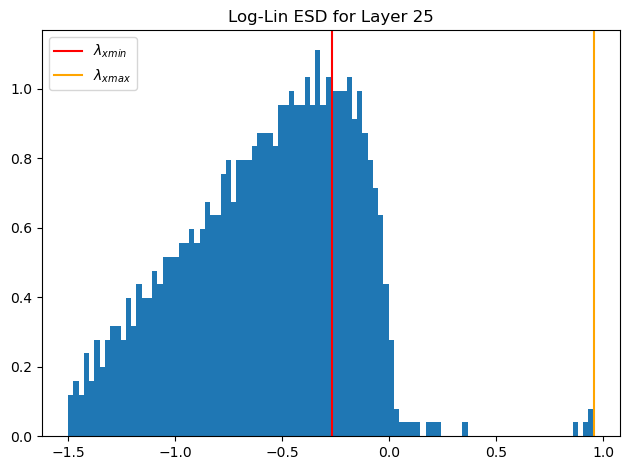

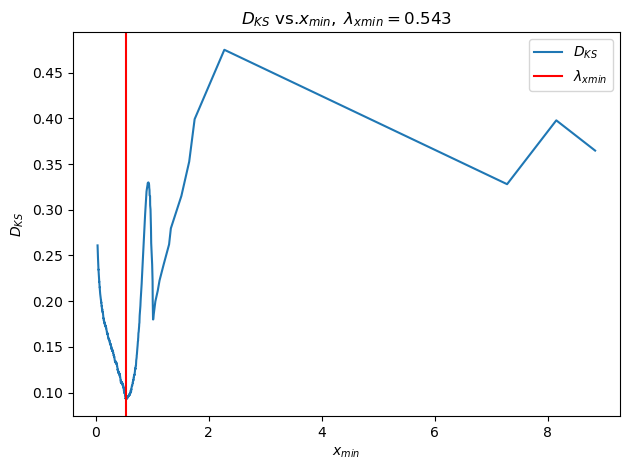

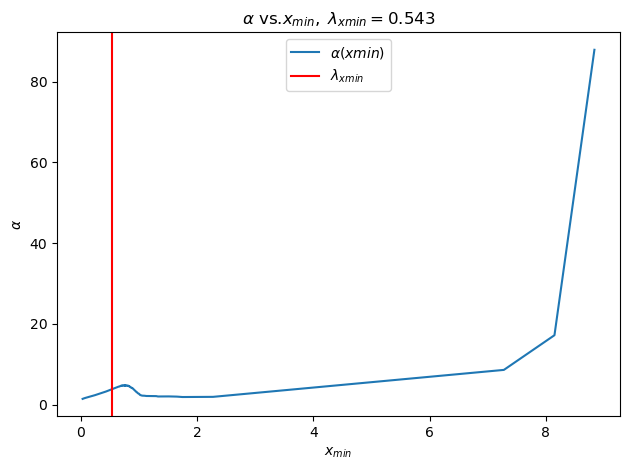

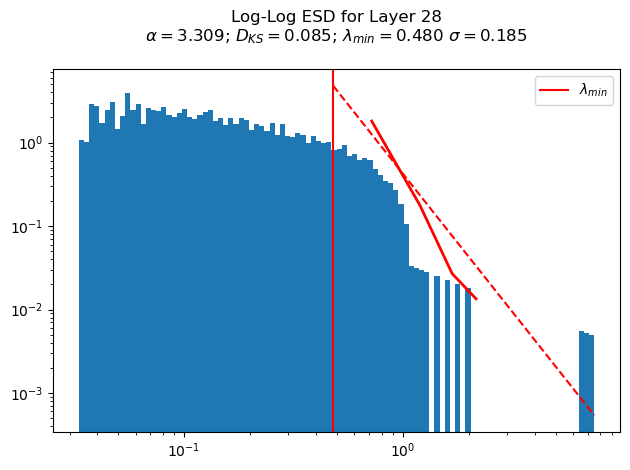

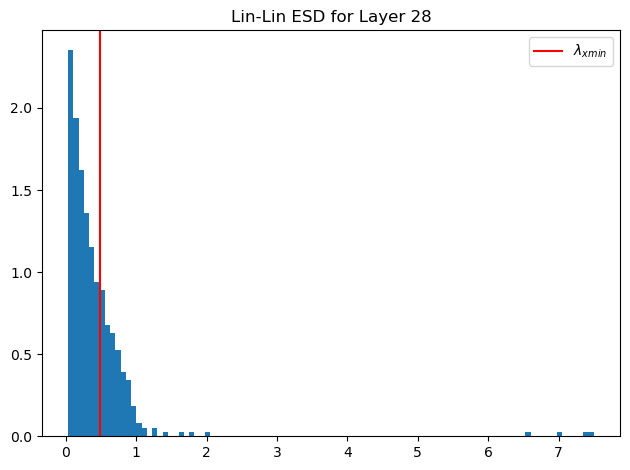

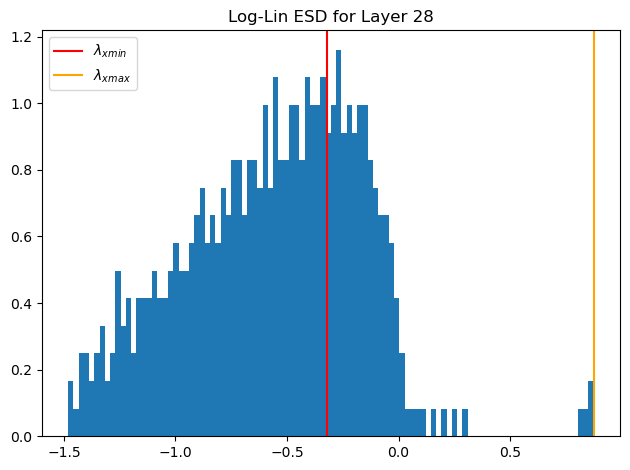

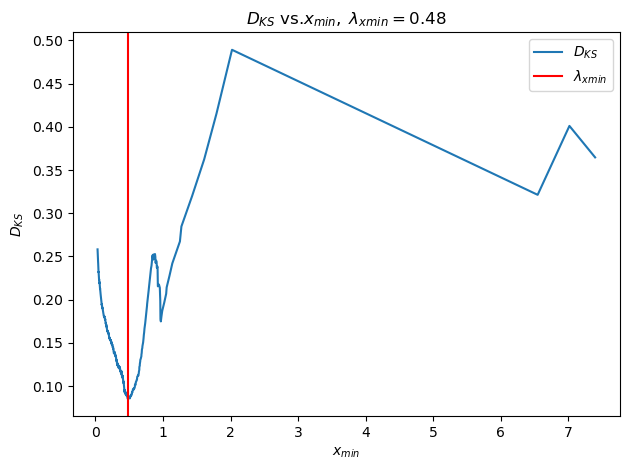

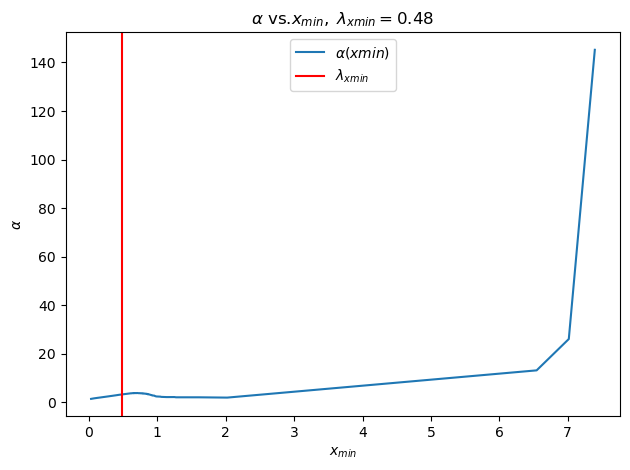

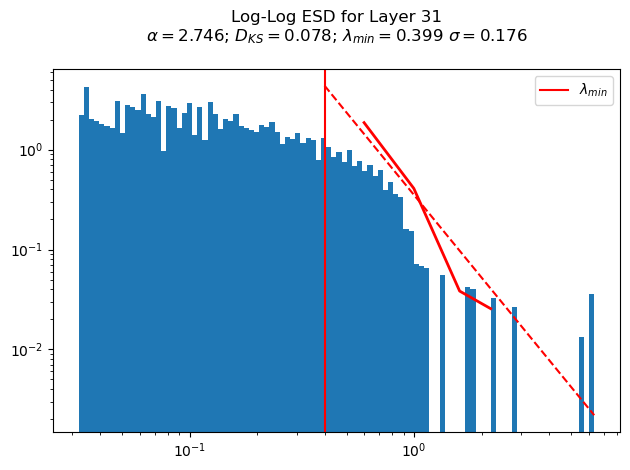

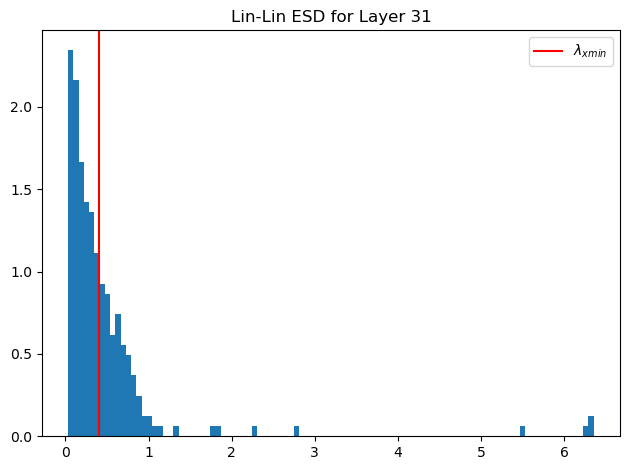

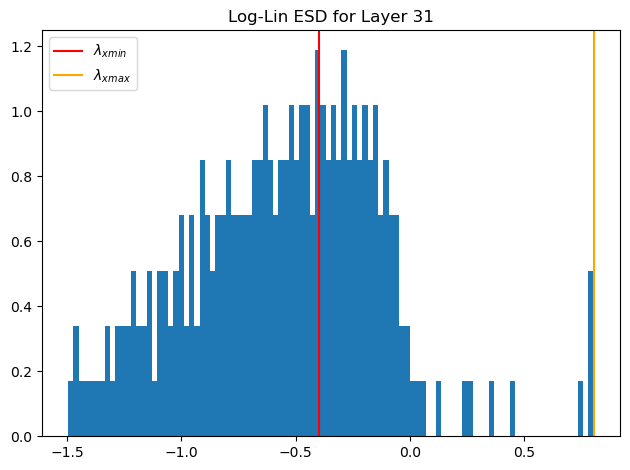

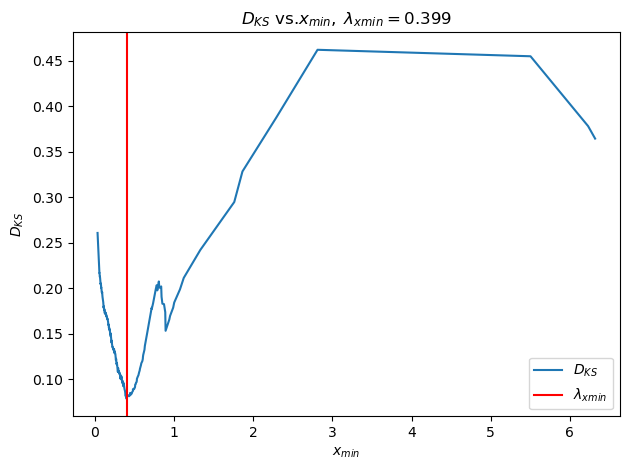

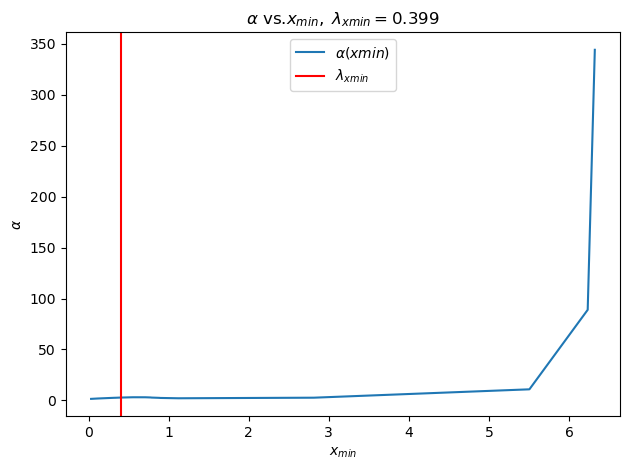

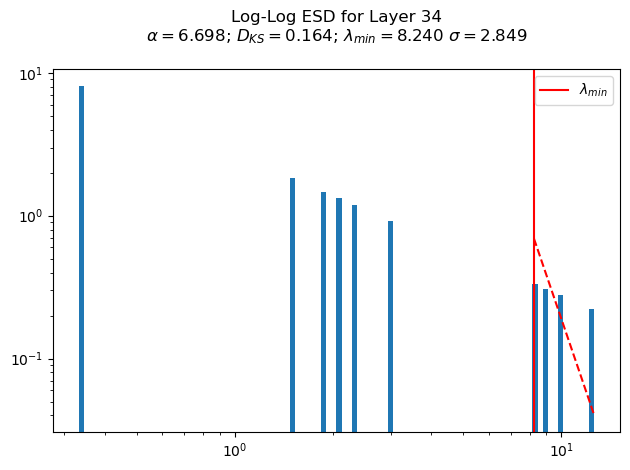

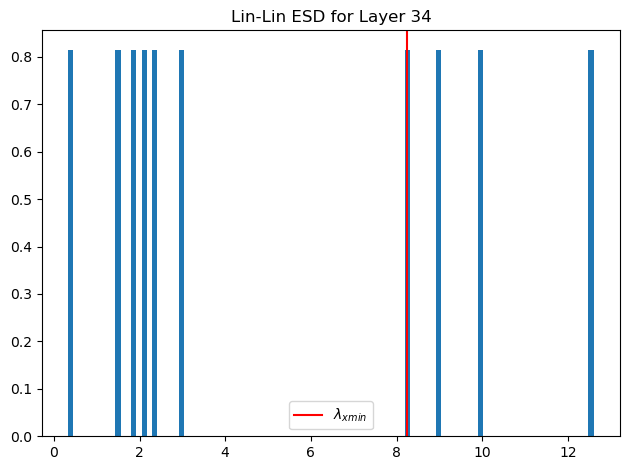

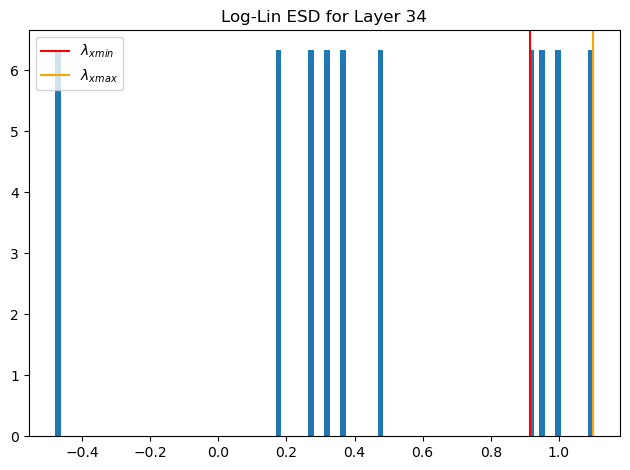

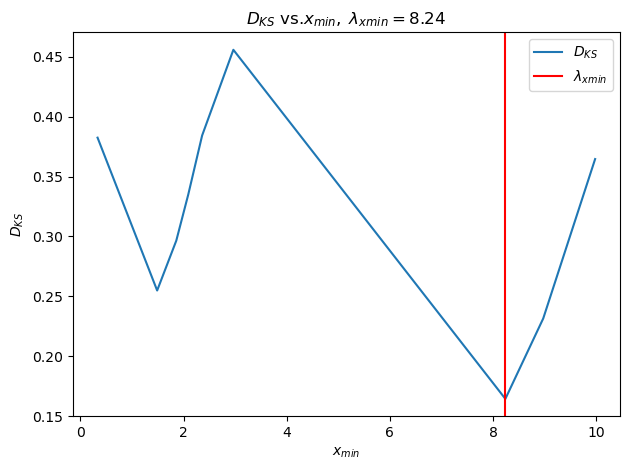

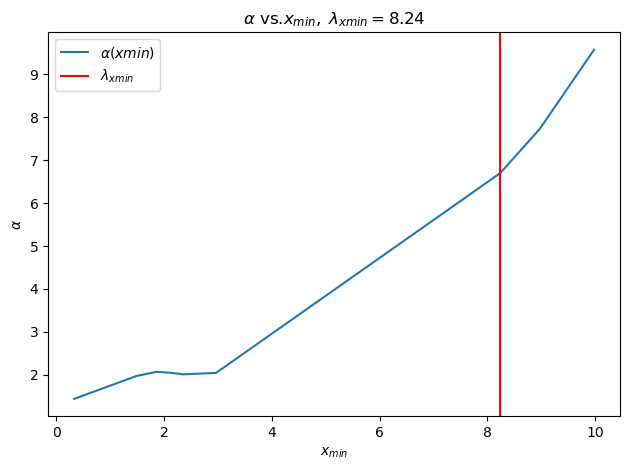

Skipping conv2d_1 (Epoch 1): missing log-log data
Skipping conv2d_3 (Epoch 1): missing log-log data
Skipping conv2d_5 (Epoch 1): missing log-log data
Skipping conv2d_7 (Epoch 1): missing log-log data
Skipping conv2d_9 (Epoch 1): missing log-log data
Skipping conv2d_11 (Epoch 1): missing log-log data
Skipping conv2d_13 (Epoch 1): missing log-log data
Skipping conv2d_15 (Epoch 1): missing log-log data
Skipping dense_19 (Epoch 1): missing log-log data
Skipping dense_22 (Epoch 1): missing log-log data
Skipping dense_25 (Epoch 1): missing log-log data
Skipping dense_28 (Epoch 1): missing log-log data
Skipping dense_31 (Epoch 1): missing log-log data
Skipping dense_34 (Epoch 1): missing log-log data


<Figure size 640x480 with 0 Axes>

In [76]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import weightwatcher as ww

import os
import matplotlib.pyplot as plt

def generate_friendly_layer_names(details_df):
    for i, row in details_df.iterrows():
        layer_type = row.get("layer_type", "Layer")
        layer_id = row.get("layer_id", i)
        details_df.at[i, "friendly_name"] = f"{layer_type}_{layer_id}"
    return details_df

def analyze_esd_and_plot(model, epoch=None, save_dir="esd_plots"):
    """
    Uses WeightWatcher to extract ESD and log-log plots from model weights
    and saves plots in per-epoch subfolders with titles showing layer names and α values.
    """
    watcher = ww.WeightWatcher(model=model)
    details = watcher.analyze(plot=True)
    details = details[details['has_esd'] == True]

    if details.empty:
        print(f"No valid ESD data found at epoch {epoch}")
        return

    details = generate_friendly_layer_names(details)

    epoch_folder = os.path.join(save_dir, f"epoch_{epoch}")
    os.makedirs(epoch_folder, exist_ok=True)

    for idx, row in details.iterrows():
        layer_name = row.get('friendly_name', f"Layer_{idx}")
        alpha = row.get('alpha', None)
        log_x = row.get('log_x', [])
        log_y = row.get('log_y', [])
        pl_fit = row.get('pl_fit', [])

        if not log_x or not log_y or not pl_fit:
            print(f"Skipping {layer_name} (Epoch {epoch}): missing log-log data")
            continue

        # Plot log-log ESD and power-law fit
        plt.figure(figsize=(8, 6))
        plt.plot(log_x, log_y, label='Log-Log ESD', color='blue')
        if alpha:
            plt.plot(log_x, pl_fit, '--', color='red', label=f'Power Law Fit (α = {alpha:.2f})')

        # Add epoch number to the title
        plt.title(f"{layer_name} - Epoch {epoch}\nα = {alpha:.2f}" if alpha else f"{layer_name} - Epoch {epoch}")
        plt.xlabel("log λ")
        plt.ylabel("log ρ(λ)")
        plt.grid(True)
        plt.legend()

        layer_clean = layer_name.replace(" ", "_").lower()
        filename = os.path.join(epoch_folder, f"{layer_clean}_epoch_{epoch}.png")

        # Ensure unique filenames
        counter = 1
        while os.path.exists(filename):
            filename = os.path.join(epoch_folder, f"{layer_clean}_epoch_{epoch}_{counter}.png")
            counter += 1

        # Save the plot and close
        plt.savefig(filename)
        plt.close()
        print(f"✅ Saved: {filename}")


def load_checkpoint(checkpoint_path, model, optimizer):
    """
    Loads model and optimizer state from a specific checkpoint file.
    """
    checkpoint = torch.load(checkpoint_path, map_location='cpu')  # safer for portability
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer

# === Main (For Specific Checkpoint) ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_path = "/home/lab-01/Desktop/ADVST_ANCHAL_GUPTA/AG-1/training_checkpoints/checkpoint_epoch_50.pth"
save_dir = "esd_plots"

model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Load the model and optimizer from the specified checkpoint file
print(f"\n🔍 Analyzing ESD for checkpoint: {checkpoint_path}")
model, optimizer = load_checkpoint(checkpoint_path, model, optimizer)

# Analyze and plot ESD for the specific checkpoint
epoch = 1  # For a specific checkpoint (you can modify if needed)
analyze_esd_and_plot(model, epoch=epoch, save_dir=save_dir)

## Making Videos

In [82]:
!pip install imageio imageio-ffmpeg --break-system-packages

Defaulting to user installation because normal site-packages is not writeable


In [85]:
!pip install natsort --break-system-packages

Defaulting to user installation because normal site-packages is not writeable


In [86]:
import os
import imageio
from natsort import natsorted  # To naturally sort files like epoch1, epoch2, epoch10

# Define the path to your image folder
image_folder = "/home/lab-01/Desktop/ADVST_ANCHAL_GUPTA/AG-1/Global Weight & Bias/global_parameters/biases"
output_video_path = os.path.join(image_folder, "global_biases.mp4")

# Get all PNG files in folder
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]

# Sort them in natural order: epoch1.png, epoch2.png, ..., epoch50.png
images = natsorted(images)

# Set frame rate (frames per second)
fps = 2

# Read images and write video
with imageio.get_writer(output_video_path, fps=fps) as writer:
    for img_name in images:
        img_path = os.path.join(image_folder, img_name)
        image = imageio.imread(img_path)
        writer.append_data(image)

print(f"✅ Video saved at: {output_video_path}")


2025-04-21 14:01:42,363 - WARNING - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ Video saved at: /home/lab-01/Desktop/ADVST_ANCHAL_GUPTA/AG-1/Global Weight & Bias/global_parameters/biases/global_biases.mp4


In [87]:
import os
import imageio
from natsort import natsorted  # To naturally sort files like epoch1, epoch2, epoch10

# Define the path to your image folder
image_folder = "/home/lab-01/Desktop/ADVST_ANCHAL_GUPTA/AG-1/Global Weight & Bias/global_parameters/weights"
output_video_path = os.path.join(image_folder, "global_weights.mp4")

# Get all PNG files in folder
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]

# Sort them in natural order: epoch1.png, epoch2.png, ..., epoch50.png
images = natsorted(images)

# Set frame rate (frames per second)
fps = 2

# Read images and write video
with imageio.get_writer(output_video_path, fps=fps) as writer:
    for img_name in images:
        img_path = os.path.join(image_folder, img_name)
        image = imageio.imread(img_path)
        writer.append_data(image)

print(f"✅ Video saved at: {output_video_path}")


2025-04-21 14:03:03,028 - WARNING - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ Video saved at: /home/lab-01/Desktop/ADVST_ANCHAL_GUPTA/AG-1/Global Weight & Bias/global_parameters/weights/global_weights.mp4


In [140]:
import os
import imageio
from natsort import natsorted  # To naturally sort files like epoch1, epoch2, epoch10

# Define the path to your image folder
image_folder = "/home/lab-01/Desktop/ADVST_ANCHAL_GUPTA/AG-1/Histogram/fc6/biases"
output_video_path = os.path.join(image_folder, "fc6_biases.mp4")

# Get all PNG files in folder
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]

# Sort them in natural order: epoch1.png, epoch2.png, ..., epoch50.png
images = natsorted(images)

# Set frame rate (frames per second)
fps = 2

# Read images and write video
with imageio.get_writer(output_video_path, fps=fps) as writer:
    for img_name in images:
        img_path = os.path.join(image_folder, img_name)
        image = imageio.imread(img_path)
        writer.append_data(image)

print(f"✅ Video saved at: {output_video_path}")

2025-04-21 14:16:16,032 - WARNING - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ Video saved at: /home/lab-01/Desktop/ADVST_ANCHAL_GUPTA/AG-1/Histogram/fc6/biases/fc6_biases.mp4


In [210]:
import os
import imageio
from natsort import natsorted  # To naturally sort files like epoch1, epoch2, epoch10

# Define the path to your image folder
image_folder = "/home/lab-01/Desktop/ADVST_ANCHAL_GUPTA/AG-1/Histogram/fc6/weights"
output_video_path = os.path.join(image_folder, "fc5_weights.mp4")

# Get all PNG files in folder
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]

# Sort them in natural order: epoch1.png, epoch2.png, ..., epoch50.png
images = natsorted(images)

# Set frame rate (frames per second)
fps = 2

# Read images and write video
with imageio.get_writer(output_video_path, fps=fps) as writer:
    for img_name in images:
        img_path = os.path.join(image_folder, img_name)
        image = imageio.imread(img_path)
        writer.append_data(image)

print(f"✅ Video saved at: {output_video_path}")

2025-04-21 15:57:31,280 - WARNING - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ Video saved at: /home/lab-01/Desktop/ADVST_ANCHAL_GUPTA/AG-1/Histogram/fc6/weights/fc5_weights.mp4


In [209]:
import os
import imageio
from natsort import natsorted  # To naturally sort files like epoch1, epoch2, epoch10

# Define the path to your image folder
image_folder = "/home/lab-01/Desktop/ADVST_ANCHAL_GUPTA/AG-1/esd_plots/epochs_50"
output_video_path = os.path.join(image_folder, "epochs_50_esd.mp4")

# Get all PNG files in folder
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]

# Sort them in natural order: epoch1.png, epoch2.png, ..., epoch50.png
images = natsorted(images)

# Set frame rate (frames per second)
fps = 2

# Read images and write video
with imageio.get_writer(output_video_path, fps=fps) as writer:
    for img_name in images:
        img_path = os.path.join(image_folder, img_name)
        image = imageio.imread(img_path)
        writer.append_data(image)

print(f"✅ Video saved at: {output_video_path}")

✅ Video saved at: /home/lab-01/Desktop/ADVST_ANCHAL_GUPTA/AG-1/esd_plots/epochs_50/epochs_50_esd.mp4
